# <center><span style = "font-size:1.5em;">  Climate Change Sentiment Analysis
#### <center><span style = "font-size:1em;"> Classification AM3

## Overview

Tasked with analysing the sentiment behind a number of tweets gathered from the  Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo, discussed in this notebook are the processes which were involved in the cleaning and preprocessing of the tweets, which serves to allow them to be used in building a classifier which will determine the sentiments of the respective authors of the tweets.

## Context

### <center> EDSA Climate Change Belief Analysis 2021

Over the years more and more companies have come to realise the benefits of paying attention to the impact their operations have on the environment as an increasing number of consumers become concerned the reduction of their and their brand of choice's carbon footprint reduction.  Consumers who support the idea of a human driven change in climate tend to support companies that are more environmentally friendly, for instance those that have moved from the use of plastic to that paper and other alternatives.  

For this reason, it is worthwhile for a company to observe the opinions of existing and potential clients in order to establish public opinion and adjust their marketing practices accordingly.

#### Problem Statement

It is with this in mind, that team Classification_AM3 set out to perform a thorough analysis of sentiments held by the public at large in order to gather public opinion which in turn influences business decisions.

The task at hand involves nature language processing, through which a number of tweets are gathered to be cleaned, removing unnecesary properties such as url addresses, twitter handles, @mentions, and #hastags, as well as the removal of punctuation, special characters and stopswords (words commonly used the english language that do not contribute to the analysis).  The tweets are then vectorized, and feature engineering is performed in order to transform the words used in the tweets into predictors to be fed into the classifier in order to classify each tweet to the appropriate label.

## Table of Contents  
<a id='toc'></a>
1. [Importing and Installing Libraries](#libraries)  



2. [Load Training Data](#train)  
    


3. [Load Testing Data](#test)   
     


4. [Text Preprocessing](#cleaning)

    4.1. Noise Removal
    
    4.2. Tokenisation and Stopwords Removal
    
    4.3. Lemmatization
    


5. [Exploratory Data Analysis](#eda) 

    5.1. Label Analysis
    
    5.2. Predictor Analysis
    
    


6. [Feature Extraction](#vect)

    6.1. CountVectorizer
    
    6.2. Train Test Split
    



7. [Model Training](#modelling)

    7.1. Logistic Regression Classifier
        7.1.1. Model Performance
    
    7.2. SMOTE Logistic Regression Classifier
        7.2.1. Model Performance
    
    7.3. Support Vector Classifer
        7.3.1. Model Performance
    
    7.4. Naive Bayes Classifier
        7.4.1. Model Performance
    


8. [Test Data](#tes)

    8.1. Logistic Regression 
        8.1.1. Logistic Regression Submission
    
    8.2. Support Vector 
        8.2.1. Support Vector Submission
    
    8.3. Naive Bayes
        8.2.3 Naive Bayes Submission
  



9. [Conclusion](#conclude)

    9.1. Model Findings
    
    9.2. Insights



10. [Model Pickling](#pickle)

    Logistic Regression
    
    Support Vector 
    
    Naive Bayes


In [ ]:
# Import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="vJUo9ahBGdk2sNcgaTzia7Z0T",
    project_name="classification-predict",
    workspace="katlehomphuthi",
)

## 1. Importing and Installing Libraries 
<a id='libraries'></a>
[Back to table of contents](#toc)

In [1]:
# Download packages
#!pip install plotly
#!pip install stopwordsiso
#!pip install yellowbrick
#!pip install imblearn

# Libraries used to load dataframe and visualize data
import numpy as np 
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.features import RadViz
from wordcloud import WordCloud
import plotly.io as pio
pio.renderers.default='notebook'
%matplotlib inline

# Noise removal helper libraries
import re
import string 
from stopwordsiso import stopwords as sw
from nltk.corpus import stopwords

# Text Preprocessing
from nltk.tokenize import TweetTokenizer
from nltk import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Feature Engineering and Data preparation for modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Model building and training
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#Model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

#save the final model and vectorizer
import pickle

## 2. Load Training Data
<a id='train'></a>
[Back to table of contents](#toc)

Load the train and test datasets, then visualize the first ten rows in each dataframe, using the `head()` method, allowing for maximum column width in the **message** column.

In [2]:
# Load the training dataset
train = pd.read_csv(r"train.csv")

# Display the first 10 rows training dataset dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(train.head(10))

sentiment  \
0          1   
1          1   
2          2   
3          1   
4          1   
5          1   
6          1   
7          1   
8          1   
9          1   

                                                                                                                                                    message  \
0              PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable   
1                                                                                            It's not like we lack evidence of anthropogenic global warming   
2              RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…   
3                                                       #TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD   
4                                RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight   
5                                            Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j   
6                                   RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R   
7  RT @makeandmendlife: Six big things we can ALL do today to fight climate change, or how to be a climate activistÃ¢â‚¬Â¦ https://t.co/TYMLu6DbNM hÃ¢â‚¬Â¦   
8               @AceofSpadesHQ My 8yo nephew is inconsolable. He wants to die of old age like me, but will perish in the fiery hellscape of climate change.   
9                                                                  RT @paigetweedy: no offense… but like… how do you just not believe… in global warming………   

   tweetid  
0   625221  
1   126103  
2   698562  
3   573736  
4   466954  
5   425577  
6   294933  
7   992717  
8   664510  
9   260471

## 3. Load Testing Data
<a id='test'></a>
[Back to table of contents](#toc)

In [3]:
# Load the testing dataset
test = pd.read_csv(r"test_with_no_labels.csv")

# Display the first 10 rows testing dataset dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(test.head(10))

message  \
0                          Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq   
1               Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj   
2        The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..   
3  @Karoli @morgfair @OsborneInk @dailykos \r\nPutin got to you too Jill ! \r\nTrump doesn't believe in climate change at all \r\nThinks it's s hoax   
4                                                                 RT @FakeWillMoore: 'Female orgasms cause global warming!'\r\n-Sarcastic Republican   
5   RT @nycjim: Trump muzzles employees of several gov’t agencies in effort to suppress info on #climate change &amp; the environment. https://t.co…   
6       @bmastenbrook yes wrote that in 3rd yr Comp Sci ethics part. Was told by climate change denying Lecturer that I was wrong &amp; marked down.   
7                       RT @climatehawk1: Indonesian farmers weather #climate change w/ conservation agriculture | @IPSNews https://t.co/1NZUCCMlYr…   
8                                  RT @guardian: British scientists face a ‘huge hit’ if the US cuts climate change research https://t.co/KlKQnYDXzh   
9            Aid For Agriculture | Sustainable agriculture and climate change adaptation for small-scale farmers https://t.co/q7IPCP59x9 via @aid4ag   

   tweetid  
0   169760  
1    35326  
2   224985  
3   476263  
4   872928  
5    75639  
6   211536  
7   569434  
8   315368  
9   591733

## 4. Text Preprocessing
<a id='cleaning'></a>
[Back to table of contents](#toc)

The two dataframes contain a high amount of noise, as is to be expected from twitter data. In addition to the above mentioned noise, which is to be expected in twitter data, there appears to be numerical values which will be removed as they have no significance in nature language processing. 

### 4.1. Noise Removal

Below we create a function called **text_preprocessing** which is then used to remove noise from both the train and test datasets.  We name the new cleaned datasets **clean_train**, and **clean_test** respectively.

In [4]:
# Create dataframe cleaning function
def text_preprocessing (df):
    
    """This function removes noise from a dataframe containing text data.  It removes url addresses, all instances of numerical
       values, twitter handles (in the form '@handle'), as well as all occurences of non-ascii characters, all using predefined
       regex patterns from the re library.  It also removes punctuation,  using the `punctuation` method from the string library, and finally, it 
       changes all the text data into lowercase form
       
       Parameters
       ----------
       df : <class 'pandas.core.frame.DataFrame'>
           The dataframe with text data that to be cleared of noise
           
       Returns
       -------
       Pandas DataFrame : <class 'pandas.core.frame.DataFrame'>
           A clean dataframe that has been cleared of noise
       """
    
    # Regex pattern for url addresses
    pattern_url = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)' 
    
    # Regex patter for numerical values
    pattern_digits = r'\d+'
    
    # Regex pattern for twitter handles
    pattern_handles = r'@(\w+)'
    
    # Create a copy of the original dataframe to perform cleaning on
    df = df.copy()
    
    # Use the url regex pattern  to remove website addresses
    df['message'] = df['message'].replace(to_replace = pattern_url, value = '', regex = True)
    
    # Use numerical values regex pattern to remove digits 
    df['message'] = df['message'].replace(to_replace = pattern_digits, value = '', regex = True)
    
    # Use the twitter handle regex pattern to remove handles
    df['message'] = df['message'].replace(to_replace = pattern_handles, value = '', regex = True)
    
    # Create a function low that converts text to lowercase
    low = lambda tweets: ''.join([tweet.lower() for tweet in tweets])
    df['message'] = df['message'].apply(low) # The low function is used convert values in the message column to lowercase
    
    # Create a function punct that removes punctuation from a dataframe
    punct = lambda tweets: ''.join([tweet for tweet in tweets if tweet not in string.punctuation])
    df['message'] = df['message'].apply(punct)# The punct function is used ot remove punctuation from the message column
    
    # Use a regex pattern to remove non-ascii characters from the message column in the dataframe
    df.message.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
    
    #return the final dataframe object which has undergone noise removal
    return df

In [5]:
# Call dataframe cleaning function with the testing dataset as input, creating a new, clean training dataset dataframe
clean_train = text_preprocessing(train)

# Display the first 10 row of the clean training dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(clean_train.head(10))

sentiment  \
0          1   
1          1   
2          2   
3          1   
4          1   
5          1   
6          1   
7          1   
8          1   
9          1   

                                                                                                                     message  \
0                     polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what  via    
1                                                              its not like we lack evidence of anthropogenic global warming   
2                                     rt  researchers say we have three years to act on climate change before its too late     
3                                                      todayinmaker wired   was a pivotal year in the war on climate change    
4                            rt  its  and a racist sexist climate change denying bigot is leading in the polls electionnight   
5                                                            worth a read whether you do or dont believe in climate change     
6                                        rt  mike pence doesnt believe in global warming or that smoking causes lung cancer    
7                          rt  six big things we can all do today to fight climate change or how to be a climate activist  h   
8   my yo nephew is inconsolable he wants to die of old age like me but will perish in the fiery hellscape of climate change   
9                                                      rt  no offense but like how do you just not believe in global warming   

   tweetid  
0   625221  
1   126103  
2   698562  
3   573736  
4   466954  
5   425577  
6   294933  
7   992717  
8   664510  
9   260471

In [6]:
# Call the dataframe cleaning function with the testing dataset as input, creating a new, clean testing dataset dataframe
clean_test = text_preprocessing(test)

# Display the first 10 rows of the clean testing dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(clean_test.head(10))

message  \
0                           europe will now be looking to china to make sure that it is not alone in fighting climate change    
1                 combine this with the polling of staffers re climate change and womens rights and you have a fascist state    
2                        the scary unimpeachable evidence that climate change is already here  itstimetochange climatechange    
3                      \r\nputin got to you too jill  \r\ntrump doesnt believe in climate change at all \r\nthinks its s hoax   
4                                                             rt  female orgasms cause global warming\r\nsarcastic republican   
5      rt  trump muzzles employees of several govt agencies in effort to suppress info on climate change amp the environment    
6   yes wrote that in rd yr comp sci ethics part was told by climate change denying lecturer that i was wrong amp marked down   
7                                                 rt  indonesian farmers weather climate change w conservation agriculture      
8                                              rt  british scientists face a huge hit if the us cuts climate change research    
9                     aid for agriculture  sustainable agriculture and climate change adaptation for smallscale farmers  via    

   tweetid  
0   169760  
1    35326  
2   224985  
3   476263  
4   872928  
5    75639  
6   211536  
7   569434  
8   315368  
9   591733

### 4.2. Tokenisation and Stopwords Removal

The two dataframes have now been cleared of most of the described noise, however there are still stopwords that can be be seen in both dataframes, words such as **"will"**, **"got"**, and **"was"** as seen the the above cleaned test dataset, **clean_test**.  Below  is function **tokens** created to tokenize (split up all the words in each tweet) each observation.  This function is used to create two new dataframes **tokenized_train**, and **tokenized_test** which will be used for easier removal of stopwords.  There are also the abbreviations "rt" (short for the twitter specific word retweets) remaining for the cleaning performed above, which are removed along with the stopwords.

In [7]:
# Create function that tokenizes the words in a dataframe
def tokens(df, column_name):
    """The function uses TweetTokenizer from the nltk tokenize library to tokenize the words in a sentence in a dataframe
    
       Parameters
       ----------
       df : <class 'pandas.core.frame.DataFrame'>
           The dataframe to be tokenized
           
       column_name : str
           The name of the column in the dataframe to be tokenized
           
       returns
       -------
       Pandas DataFrame : <class 'pandas.core.frame.DataFrame'>
           The dataframe with a column that has been tokenized"""
    
    # Create a copy of the dataframe to perform tokenization on
    df = df.copy()
    
    # Instantiate TweetTokenizer, as tknzr, with reduce_len to remove redundant lettering in words
    # e.g 'yessss' transormed to 'yes'
    tknzr = TweetTokenizer(reduce_len = True)
    
    # Format the message column using TweetTokenizer
    df[column_name] = df[column_name].apply(tknzr.tokenize)
    
    # Return a dataframe object that has been tokenized
    return df

In [8]:
# Call the tokens function on the clean training dataset dataframe and message column, 
# creating a new tokenized training dataframe
tokens_train = tokens(clean_train, 'message')

# Display the first 10 row in the tokenized training dataset dataframe, allowing for maximum width in the message column
with pd.option_context('display.max_colwidth', 400):
    display(tokens_train.head(10))

sentiment  \
0          1   
1          1   
2          2   
3          1   
4          1   
5          1   
6          1   
7          1   
8          1   
9          1   

                                                                                                                                             message  \
0                             [polyscimajor, epa, chief, doesnt, think, carbon, dioxide, is, main, cause, of, global, warming, and, wait, what, via]   
1                                                                           [its, not, like, we, lack, evidence, of, anthropogenic, global, warming]   
2                                               [rt, researchers, say, we, have, three, years, to, act, on, climate, change, before, its, too, late]   
3                                                                    [todayinmaker, wired, was, a, pivotal, year, in, the, war, on, climate, change]   
4                                     [rt, its, and, a, racist, sexist, climate, change, denying, bigot, is, leading, in, the, polls, electionnight]   
5                                                                         [worth, a, read, whether, you, do, or, dont, believe, in, climate, change]   
6                                                   [rt, mike, pence, doesnt, believe, in, global, warming, or, that, smoking, causes, lung, cancer]   
7                              [rt, six, big, things, we, can, all, do, today, to, fight, climate, change, or, how, to, be, a, climate, activist, h]   
8  [my, yo, nephew, is, inconsolable, he, wants, to, die, of, old, age, like, me, but, will, perish, in, the, fiery, hellscape, of, climate, change]   
9                                                                [rt, no, offense, but, like, how, do, you, just, not, believe, in, global, warming]   

   tweetid  
0   625221  
1   126103  
2   698562  
3   573736  
4   466954  
5   425577  
6   294933  
7   992717  
8   664510  
9   260471

In [9]:
# Call the tokens function on the clean testing dataset dataframe and message column, creating a new tokenized testing dataframe
tokens_test = tokens(clean_test, 'message')

# Display the first 10 rows of the tokenized testing dataset dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(tokens_test.head(10))

message  \
0                                [europe, will, now, be, looking, to, china, to, make, sure, that, it, is, not, alone, in, fighting, climate, change]   
1                      [combine, this, with, the, polling, of, staffers, re, climate, change, and, womens, rights, and, you, have, a, fascist, state]   
2                                     [the, scary, unimpeachable, evidence, that, climate, change, is, already, here, itstimetochange, climatechange]   
3                                        [putin, got, to, you, too, jill, trump, doesnt, believe, in, climate, change, at, all, thinks, its, s, hoax]   
4                                                                                [rt, female, orgasms, cause, global, warming, sarcastic, republican]   
5            [rt, trump, muzzles, employees, of, several, govt, agencies, in, effort, to, suppress, info, on, climate, change, amp, the, environment]   
6  [yes, wrote, that, in, rd, yr, comp, sci, ethics, part, was, told, by, climate, change, denying, lecturer, that, i, was, wrong, amp, marked, down]   
7                                                                   [rt, indonesian, farmers, weather, climate, change, w, conservation, agriculture]   
8                                                         [rt, british, scientists, face, a, huge, hit, if, the, us, cuts, climate, change, research]   
9                                  [aid, for, agriculture, sustainable, agriculture, and, climate, change, adaptation, for, smallscale, farmers, via]   

   tweetid  
0   169760  
1    35326  
2   224985  
3   476263  
4   872928  
5    75639  
6   211536  
7   569434  
8   315368  
9   591733

In [10]:
# Create a function that removes stop words and 'rt' (retweet) from a dataframe column
def stop(df, column_name):
    """The function removes stopwords from a dataframe column which has been tokenized.  It uses the stopwordsiso stopwords set
       in order to remove these stopwords.  The function also removes all instances of the twitter specific 'rt' which indicates
       the beginning of a tweet which has been retweeted
       
       Parameters
       ----------
       df : <class 'pandas.core.frame.DataFrame'>
           A dataframe containing a column with tokenized words
           
       column_name : str
           The name of the tokenized text column to remove the stopwords from
           
       Returns
       -------
       Parameters
       ----------
       Pandas DataFrame : <class 'pandas.core.frame.DataFrame'>
           A dataframe which has stopwords and instances of 'rt' removed"""
    
    # Create a copy of the dataframe stopwords removal is performed on
    df = df.copy()
    
    # Create a function, rt, that returns tokenized words which are not 'rt'
    rt = lambda tweets: [tweet for tweet in tweets if tweet != 'rt']
    
    # Use the rt function on the specified dataframe column, removing all 'rt'instances from each observation
    df[column_name] = df[column_name].apply(rt)
    
    #Create a function stops which returns the words in a tokenized dataframe that do not appear in a stopwords set
    stops = lambda tweets: [tweet for tweet in tweets if tweet not in sw('en')]
    
    # Use the stops function on the specified dataframe column, removing all stopwords
    df[column_name] = df[column_name].apply(stops)
    
    #Return the dataframe without rts and stopwords
    return df

In [11]:
# Call the stop function on the tokenized training dataset dataframe, creating a new training dataframe without stopwords and rts
stops_train = stop(tokens_train, 'message')

# Display the first 10 rows of the training dataframe without stopwords and rts, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(stops_train.head(10))

sentiment  \
0          1   
1          1   
2          2   
3          1   
4          1   
5          1   
6          1   
7          1   
8          1   
9          1   

                                                                            message  \
0          [polyscimajor, epa, chief, carbon, dioxide, main, global, warming, wait]   
1                                  [lack, evidence, anthropogenic, global, warming]   
2                                              [researchers, climate, change, late]   
3                              [todayinmaker, wired, pivotal, war, climate, change]   
4  [racist, sexist, climate, change, denying, bigot, leading, polls, electionnight]   
5                                                    [worth, read, climate, change]   
6                             [mike, pence, global, warming, smoking, lung, cancer]   
7                                       [fight, climate, change, climate, activist]   
8   [yo, nephew, inconsolable, die, age, perish, fiery, hellscape, climate, change]   
9                                                        [offense, global, warming]   

   tweetid  
0   625221  
1   126103  
2   698562  
3   573736  
4   466954  
5   425577  
6   294933  
7   992717  
8   664510  
9   260471

In [12]:
# Call the stops function the tokenized testing dataset dataframe, creating a new testing dataframe without stopwords and rts
stops_test = stop(tokens_test, 'message')

# Display the first 10 rows of the testing dataframe without stopwords and rts, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(stops_test.head(10))

message  \
0                                                              [europe, china, fighting, climate, change]   
1                                  [combine, polling, staffers, climate, change, womens, rights, fascist]   
2                       [scary, unimpeachable, evidence, climate, change, itstimetochange, climatechange]   
3                                                             [putin, jill, trump, climate, change, hoax]   
4                                               [female, orgasms, global, warming, sarcastic, republican]   
5  [trump, muzzles, employees, govt, agencies, effort, suppress, info, climate, change, amp, environment]   
6            [wrote, yr, comp, sci, ethics, told, climate, change, denying, lecturer, wrong, amp, marked]   
7                              [indonesian, farmers, weather, climate, change, conservation, agriculture]   
8                                                 [british, scientists, huge, hit, cuts, climate, change]   
9          [aid, agriculture, sustainable, agriculture, climate, change, adaptation, smallscale, farmers]   

   tweetid  
0   169760  
1    35326  
2   224985  
3   476263  
4   872928  
5    75639  
6   211536  
7   569434  
8   315368  
9   591733

### 4.3. Lemmatizaton

When creating features in natural language processing, it is worthwhile extract the root form of a word so as to avoid have multiple words, in different forms, e.g plural vs singular, that have the same meaning.  Words such as "staffers", "agencies", and "ethics" need to be returned to their root form such that when bag of words are formed, frequency grouping have words with the same meaning and not just the same spelling.  For this purpose we use `WordNetLemmatizer` from the `wordnet` library which will return the root words without cutting off suffixes.

In [13]:
# Instantiate WordNetLemmatizer as lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a new dataframe to be lemmatized using the stops_train dataframe
lemmatized_train = stops_train.copy()

# Use lemmatizer on the message column of the lemmatized_train dataframe
lemmatized_train['message'] = stops_train['message'].apply(lambda sentence : [lemmatizer.lemmatize(word) for word in sentence])

# Display the first 10 rows of the lemmatized_train dataframe, allowing maxmimum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(lemmatized_train.head(10))

sentiment  \
0          1   
1          1   
2          2   
3          1   
4          1   
5          1   
6          1   
7          1   
8          1   
9          1   

                                                                           message  \
0         [polyscimajor, epa, chief, carbon, dioxide, main, global, warming, wait]   
1                                 [lack, evidence, anthropogenic, global, warming]   
2                                              [researcher, climate, change, late]   
3                             [todayinmaker, wired, pivotal, war, climate, change]   
4  [racist, sexist, climate, change, denying, bigot, leading, poll, electionnight]   
5                                                   [worth, read, climate, change]   
6                            [mike, penny, global, warming, smoking, lung, cancer]   
7                                      [fight, climate, change, climate, activist]   
8  [yo, nephew, inconsolable, die, age, perish, fiery, hellscape, climate, change]   
9                                                       [offense, global, warming]   

   tweetid  
0   625221  
1   126103  
2   698562  
3   573736  
4   466954  
5   425577  
6   294933  
7   992717  
8   664510  
9   260471

In [14]:
# Create a new dataframe to be lemmatized using th stops_test dataframe
lemmatized_test = stops_test.copy()

# Use lemmatizer on the message column of the lemmatized_test dataframe
lemmatized_test['message'] = stops_test['message'].apply(lambda sentence: [lemmatizer.lemmatize(word) for word in sentence])

# Display the first 10 rows of the lemmatized_test dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(lemmatized_test.head(10))

message  \
0                                                          [europe, china, fighting, climate, change]   
1                                 [combine, polling, staffer, climate, change, woman, right, fascist]   
2                   [scary, unimpeachable, evidence, climate, change, itstimetochange, climatechange]   
3                                                         [putin, jill, trump, climate, change, hoax]   
4                                            [female, orgasm, global, warming, sarcastic, republican]   
5  [trump, muzzle, employee, govt, agency, effort, suppress, info, climate, change, amp, environment]   
6         [wrote, yr, comp, sci, ethic, told, climate, change, denying, lecturer, wrong, amp, marked]   
7                           [indonesian, farmer, weather, climate, change, conservation, agriculture]   
8                                               [british, scientist, huge, hit, cut, climate, change]   
9       [aid, agriculture, sustainable, agriculture, climate, change, adaptation, smallscale, farmer]   

   tweetid  
0   169760  
1    35326  
2   224985  
3   476263  
4   872928  
5    75639  
6   211536  
7   569434  
8   315368  
9   591733

Finally the tokens are joined together into full sentence once more, and the final clean and preprocessed data sets **lemmatized_train** and **lemmatized_test** can be used in feature extraction.

In [15]:
# Join the tokenized words in the lemmatized_train message column into sentences
lemmatized_train['message'] = [' '.join(tweet) for tweet in lemmatized_train['message'].values]

# Display the first 10 rows of the lemmatized_train dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(lemmatized_train.head(10))

sentiment  \
0          1   
1          1   
2          2   
3          1   
4          1   
5          1   
6          1   
7          1   
8          1   
9          1   

                                                                 message  \
0         polyscimajor epa chief carbon dioxide main global warming wait   
1                             lack evidence anthropogenic global warming   
2                                         researcher climate change late   
3                          todayinmaker wired pivotal war climate change   
4  racist sexist climate change denying bigot leading poll electionnight   
5                                              worth read climate change   
6                          mike penny global warming smoking lung cancer   
7                                  fight climate change climate activist   
8   yo nephew inconsolable die age perish fiery hellscape climate change   
9                                                 offense global warming   

   tweetid  
0   625221  
1   126103  
2   698562  
3   573736  
4   466954  
5   425577  
6   294933  
7   992717  
8   664510  
9   260471

In [16]:
# Join the tokenized words in the lemmatized_test message column into sentence 
lemmatized_test['message'] = [' '.join(tweet) for tweet in lemmatized_test['message'].values]

# Display the first 10 rows of the lemmatized_test dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(lemmatized_test.head(10))

message  \
0                                                   europe china fighting climate change   
1                             combine polling staffer climate change woman right fascist   
2              scary unimpeachable evidence climate change itstimetochange climatechange   
3                                                   putin jill trump climate change hoax   
4                                      female orgasm global warming sarcastic republican   
5  trump muzzle employee govt agency effort suppress info climate change amp environment   
6          wrote yr comp sci ethic told climate change denying lecturer wrong amp marked   
7                      indonesian farmer weather climate change conservation agriculture   
8                                          british scientist huge hit cut climate change   
9    aid agriculture sustainable agriculture climate change adaptation smallscale farmer   

   tweetid  
0   169760  
1    35326  
2   224985  
3   476263  
4   872928  
5    75639  
6   211536  
7   569434  
8   315368  
9   591733

## 5. Exploratory Data Analysis
<a id='eda'></a>
[Back to table of contents](#toc)

### 5.1. Label Analysis

The target variable in the sentiment associated with a select tweet.  The goal being to find out whether an individual believes that climate change is human driven or not.  In addition to these two sentiments, included are a neutral sentiment for individuals who do not feel strongly in either direction and lastly we have news relating to climate change.  

**There are four distinct classes**:
   - Pro (1): Indicating individuals who believe climate change is human driven.
    
   - Neutral (0): Indicating individuals who are not convinced in either direction.
    
   - Anti (-1): Indicating individuals who believe climate change is a natural occurence.
    
   - News (2): Indicates tweets related actuals news stories.

With real world data, classes seldom have an distribution of observations.  In order to determine how many tweets fall within each class, the **lemmatized_train** dataframe was grouped by class (**sentiment**) and the number of tweets per class was calculated.

In [17]:
# Create a new dataframe by grouping tweets by sentiment and counting the number of tweets in each sentiment
group = lemmatized_train.groupby('sentiment').count()['message'].reset_index().sort_values(by = 'message', ascending = False)

# Display the new dataframe.  The sentiment column displays the four classes, 
# while the message column display the number of tweets per class
group

sentiment  message
2          1     8530
3          2     3640
1          0     2353
0         -1     1296

#### Bar Plot

In [18]:
# Create a bar plot using the group dataframe  to visualise the number of tweets per class
fig = go.Figure(go.Bar(x = ['Positive', 'News', 'Neutral', 'Negative'],y = group['message'], # Specify x and y variables
                       marker = {'color': group['message'],'colorscale': 'plasma'})) # Select a colour for the graph

# Add title, x and y axis labels to the bar chart
fig.update_layout(yaxis_title = 'Tweets', xaxis_title = 'Sentiment', title = 'Number of Tweets Per Sentiment')

# Show the bar plot
fig.show()

The positive class is well represented, holding the highest number of tweets, while the negative class holds the lowest number of tweets.  This could be due to the fact that opinions of disbelief expressed over the internet with regards to climate change and other scientific theories are often met with a high amount of criticism, leaving individuals who share these opinions unwilling to voice them.

#### Funnel Chart

In [19]:
# Create a funnel chart indicating the numbers of tweets per class as a proportion
fig = go.Figure(go.Funnelarea(text = ['Positive', 'News', 'Neutral', 'Negative'], values = group['message'], 
                              marker = {'colors': group['message']}, # column to colour chart on
                              title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}, # Chart Title
                              labels = ['Positive', 'News', 'Neutral', 'Negative'])) # Legend labels

# Show the funnel chart
fig.show()

More than fifty percent of the tweets collected fall into the positive class, believing that climate change is human driven, with only twenty-three percent of the tweets being news, approximately fifteen percent are neutral, having no strong opinion on man-made climate change in either direction, and finally a minimal eight percent have no belief in a human driven change in climate.  

This is evidence of a dataset that is highly imbalanced and would require great care and perhaps resampling when building a classifier as classes with a lower amount of observation tend to be classified correctly less often than the classes with a high amount of observations. 

#### WordClouds

In order to classify tweets to one of the four mentioned classes, it is essential to evaluate the relationship between words, or a series of words, and the different classes.  Are there words that appear more frequently in one class than others? To visualise this, `wordclouds` are used.

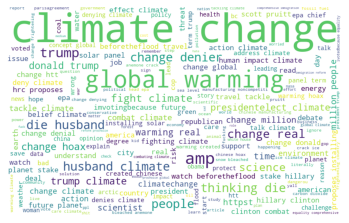

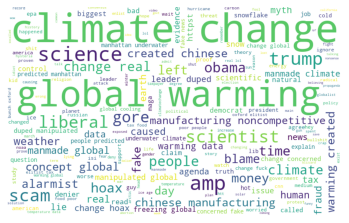

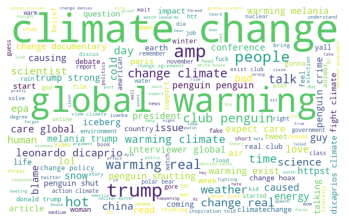

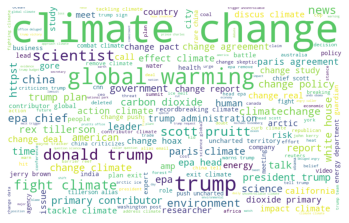

In [20]:
# Collect tweets from the lemmatized_train dataframe written by pro man-made climate change individuals
positive_words = " ".join([sentence for sentence in lemmatized_train['message'][lemmatized_train['sentiment'] == 1]])

# Instantiate  the wordcloud and use positive_words to generate a wordcloud for the 'pro' sentiment
positive_wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                               background_color = 'white').generate(positive_words)

# Plot the positive wordcloud on an empty axis and use plt.show() to display it
ax1 = plt.imshow(positive_wordcloud)
plt.axis('off')
plt.show()

# Collect tweets from the lemmatized_train dataframe written by anti man-made climate change individuals
negative_words = " ".join([sentence for sentence in lemmatized_train['message'][lemmatized_train['sentiment'] == -1]])

# Instantiate the wordcloud  and use negative_words to generate a wordcloud for the anti sentiment
negative_wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                               background_color = 'white').generate(negative_words)

# Plot the negative wordcloud on an empty axis and use plt.show() to display it
ax2 = plt.imshow(negative_wordcloud)
plt.axis('off')
plt.show()

# Collect tweets from the lemmatized_train dataframe written by individuals with neutral views on man-made climate change
neutral_words = " ".join([sentence for sentence in lemmatized_train['message'][lemmatized_train['sentiment'] == 0]])

# Instantiate the wordcloud and use neutral words to generate a wordcloud for the neutral sentiment
neutral_wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                              background_color = 'white').generate(neutral_words)

# Plot the neutral wordcloud on an empty axis and use plt.show() to display it
ax3 = plt.imshow(neutral_wordcloud)
plt.axis('off')
plt.show()

# Collect tweets from the lemmatized_train dataframe that link to actual news stories related to climate change
news_words = " ".join([sentence for sentence in lemmatized_train['message'][lemmatized_train['sentiment'] == 2]])

# Instantiate wordcloud and use news_words to generate a wordcloud for the news
news_wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                           background_color = 'white').generate(news_words)

# Plot the news wordcloud on an empty axis and use plt.show() to display it
ax4 = plt.imshow(news_wordcloud)
plt.axis('off')
plt.show()

The words **climate**, **change**, **global** and **warming** are used most frequently in the tweets.  These tweets describe the subject matter investigate **Climate Change**, thus it is to be expected that they appear often.  

This, however, leads to them taking attention away for other words that might be more class specific.  it is with this in mind, that the four words are removed and the wordcloud plotted once more. 

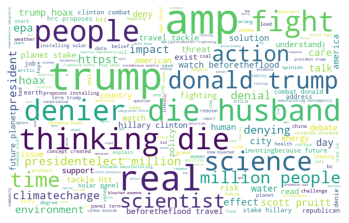

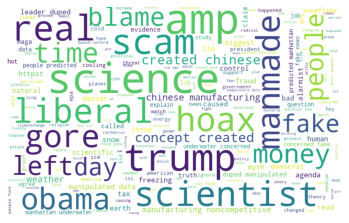

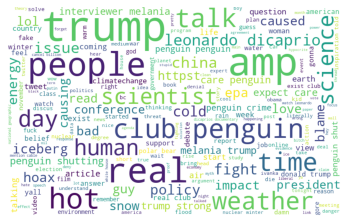

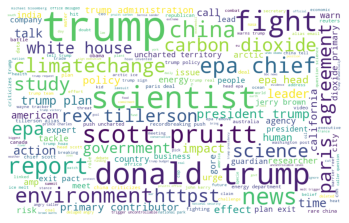

In [21]:
# Create a list of the four most frequent words in the wordclouds
climate_list = ['climate', 'change', 'global', 'warming']

# Collect tweets from positive_words excluding the frequent words from the wordclouds
new_positive = " ".join([word for word in positive_words.split() if word not in climate_list])

# Instantiate  the wordcloud and use positive_words to generate a wordcloud for the 'pro' sentiment
pos_wc = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                   background_color = 'white').generate(new_positive)

# Plot the positive wordcloud on an empty axis and use plt.show() to display it
ax1 = plt.imshow(pos_wc)
plt.axis('off')
plt.show()

# Collect tweets from negative_words excluding the frequent words from the wordclouds
new_negative = " ".join([word for word in negative_words.split() if word not in climate_list])

# Instantiate the wordcloud  and use negative_words to generate a wordcloud for the anti sentiment
neg_wc = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                               background_color = 'white').generate(new_negative)

# Plot the negative wordcloud on an empty axis and use plt.show() to display it
ax2 = plt.imshow(neg_wc)
plt.axis('off')
plt.show()

# Collect tweets from neutral_words excluding the frequent words from the wordclouds
new_neutral = " ".join([word for word in neutral_words.split() if word not in climate_list])

# Instantiate the wordcloud and use neutral words to generate a wordcloud for the neutral sentiment
neu_wc = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                              background_color = 'white').generate(new_neutral)

# Plot the neutral wordcloud on an empty axis and use plt.show() to display it
ax3 = plt.imshow(neu_wc)
plt.axis('off')
plt.show()

# Collect tweets from news_words excluding the frequent words from the wordclouds
new_news = " ".join([word for word in news_words.split() if word not in climate_list])

# Instantiate wordcloud and use news_words to generate a wordcloud for the news
new_wc = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                           background_color = 'white').generate(new_news)

# Plot the news wordcloud on an empty axis and use plt.show() to display it
ax4 = plt.imshow(new_wc)
plt.axis('off')
plt.show()

With just the removal of four words, the wordclouds give more information than they did before. 

The positive class has frequent mentions of words like **real**, **denier**, **action** and **die**, which could relate to claims of climate change being **real**, ridicule of climate change **denier**s (as if common practice on the internet), and the need to take **action** in changing habits and reducing carbon footprints.

The negative class has frequent mentions of words like **hoax**, **fake**, **scam**, and **liberal**, in which the first three words could be related to the notion that the suggestion that climate change is driven by human factors is in fact not true, while **liberal** could be linked to the notion that individuals who believe in a man-made climate change are largely liberal in their political beliefs as it is a claim often made by some Americans.

The neutral class has a mix a frequently mentioned words such as **real**, **hot**, and **human** among other words that may or may not relate to climate change.  The word **real** being the only clear single word indicator of sentiment that is prominent.

The news class, has frequent mentions of political figures, locations, environmental organisations and **news**

It is also worth noting that all classes, with the exception of the neutral class, have a high frequency of words **science**, **scientists**, and **trump**, all classes, with the exception of the news class, have a high frequency of **amp** (which might refer to the Adaptive Management Plan, and the pro and negative classes have a high frequency of **real**.  This are words that on their own cannot be attributed a sentiment, they rely on other words to give them sentimental value, **real** for example could be used in two ways "Man-made climate change is real" which is a positive sentiment, while "I can't believe people think climate change is real" would indicate a negative sentiment.

### 5.2 Predictor Analysis

**Hashtags**

Twitter hashtags often give information about an individuals views.  Hashtags are used as a means for multiple people to discuss the same topic.  For this reason, it is necessary to look at some of the hashtags used in the the training set and how they relate to the associated sentiment 

In [22]:
# Create function which extracts hashtags from the dataframe
def hashtag_extract(message):
    """The function takes in a tweet and extracts from it twitter hashtags, in the form #hashtag if one is present.
       A regex pattern from the re library is used to find all instances of words starting with the '#' hashtag sign. 
        
        Parameters
        ----------
        message : Pandas Series
            A sentence from which a hashtag will be extracted
            
        Returns
        -------
        Python list of hashtags
        """
    # Create an empty list which will be used to collect hashtags
    hashtags = []
    
    # For every word in message, find words that start with '#' and append them to the empty list
    for tweet in message: # Look through message
        ht = re.findall(r"#(\w+)", tweet) # Use regex pattern to find hashtags
        hashtags.append(ht) # Append the extracted hashtags to the empty list
        
    # Return the created list of hashtags
    return hashtags

In [23]:
# Use the hashtags extract function to get hashtags associated with the positive class from the original training dataframe
positive_hashtags = hashtag_extract(train['message'][train['sentiment'] == 1])

# Use the hashtags extract function to get hashtags associated with the negative class from the original training dataframe
negative_hashtags = hashtag_extract(train['message'][train['sentiment'] == -1])

# Use the hashtags extract function to get hashtags associated with the neutral class from the original training dataframe
neutral_hashtags = hashtag_extract(train['message'][train['sentiment'] == 0])

# Use the hashtags extract function to get hashtags associated with the news class from the original training dataframe
news_hashtags = hashtag_extract(train['message'][train['sentiment'] == 2])

With the hashtags extracted, a count of the number of times a hashtag appears in the entire document of tweets is performed, first by calling `sum` on the list hashtags for each sentiment and an empty list, creating a single list by 
removing the instances from rows in the dataframe that did not contain a hashtags.

In [24]:
# Create a single list for the positive sentiment
positive_hashtags = sum(positive_hashtags, [])

# Create a single list for the negative sentiment
negative_hashtags = sum(negative_hashtags, [])

# Create a single list for the neutral sentiment
neutral_hashtags = sum(neutral_hashtags, [])

# Create a single list for the news sentiment
news_hashtags = sum(news_hashtags, [])

Let's visualize the most frequent words in each class. We'll do this using the `FreqDistVisualizer` imported from the yellowbrick library.

In [25]:
# Create a distribution plot of the most frequent hashtags in the positive hashtags list 
freq = nltk.FreqDist(positive_hashtags)

# Create a dataframe from the result of the frequency distribution plot, using the hashtags in one column and frequencies
# in a second
df = pd.DataFrame({'Hashtags' : list(freq.keys()),
                   'Count' : list(freq.values())})

# Sort the hashtags by order of descending counts and show the first 10 rows i.e the 10 most frequent hashtags
df_pos = df.sort_values(by = 'Count', ascending = False)
df_pos.head(10)

Hashtags  Count
19           climate    187
24    BeforeTheFlood    129
68     climatechange     94
13   ImVotingBecause     62
4              COP22     59
41    ParisAgreement     50
101     ActOnClimate     42
58                 Ã     37
50             Trump     34
57     IVotedBecause     33

In [26]:
# Create a bar plot using the group dataframe  to visualise the number of tweets per class
fig = go.Figure(go.Bar(x = df_pos['Hashtags'].head(10), 
                       y = df_pos['Count'].head(10).sort_values(ascending = False), # Specify x and y variables
                       marker = {'color': df_pos['Count'],'colorscale': 'viridis'})) # Select a colour for the graph

# Add title, x and y axis labels to the bar chart
fig.update_layout(yaxis_title = 'Hashtag Counts', xaxis_title = 'Hashtags', 
                  title = 'Count of Hashtags for Positive Man-Made Climate Change Sentiment')

# Show the bar plot
fig.show()

The hashtags used in used in tweets associated with individuals who believe in a man-made change in climate are very telling of their sentiments with the exception on a special character that was missed by the text preprocessing function. It is clear that these individuals hashtagged the climate change awareness documentary, **Before The Flood** more than 100 times and **ImVotingBecause** more than 50 times, this could be related to the tweets being sourced from a time when Donald Trump was president and many American individuals were eager to vote for a politican who had different, more positive sentiments about climate change.  **COP22** and **ParisAgreement** were used frequently. COP22 refers to the twenty second climate change conference, while **ParisAgreement** refers to the legally binding international treaty on climate which was adopted at COP21.  These are the markers of individuals who have strong, positive emotion when it comes to climate change.

In [27]:
# Create a distribution plot of the most frequent hashtags in the negative hashtags list
freq = nltk.FreqDist(negative_hashtags)

# Create a dataframe the results of the frequency distribution plot , using the hashtags in the one column and frequencies
# in a second
df = pd.DataFrame({'Hashtags' : list(freq.keys()),
                   'Count' : list(freq.values())})

# Sort the hashtags by order descending counts and show the first 10 rows i.e the 10 most frequent hashtags
df_neg = df.sort_values(by = 'Count', ascending = False)
df_neg.head(10)

Hashtags  Count
30             MAGA     11
48          climate     10
12            Trump      7
72    climatechange      6
27             tcot      4
52   ParisAgreement      4
7      OpChemtrails      4
108   globalwarming      3
24      ClimateScam      3
13            QandA      3

In [28]:
# Create a bar plot using the group dataframe  to visualise the number of tweets per class
fig = go.Figure(go.Bar(x = df_neg['Hashtags'].head(10), 
                       y = df_neg['Count'].head(10).sort_values(ascending = False), # Specify x and y variables
                       marker = {'color': df_neg['Count'],'colorscale': 'viridis'})) # Select a colour for the graph

# Add title, x and y axis labels to the bar chart
fig.update_layout(yaxis_title = 'Hashtag Counts', xaxis_title = 'Hashtags', 
                  title = 'Count of Hashtags for Negative Man-Made Climate Change Sentiment')

# Show the bar plot
fig.show()

The anti climate change sentiment has a relatively high frequency of **MAGA**, **climate**, and **Trump** hashtags.  There are often claims that individuals who support the **MAGA** movement and president Donald **Trump**, a president who has alleged many a times that man-made climate change is a hoax, usually do not believe in a human driven climate change themselves. There are also a few **tcot** hashtags which stands for "Top Conservatives On Twitter", which could also be associated withh individuals who share the above mentioned sentiments.  The overall number of hashtags used in the negative tweets is lower than those used in the positive class, this could be attributed to the class imbalance in the data, there is a significantly higher number of positive tweets than negative.   

In [29]:
# Create a distribution plot of the most frequent hashtags in neutral hashtags list
freq = nltk.FreqDist(neutral_hashtags)

# Create a dataframe the results of the frequency distribution plot, using the hashtags in the one column and frequencies
# in a second
df = pd.DataFrame({'Hashtags' : list(freq.keys()),
                   'Count' : list(freq.values())})
# Sort the hashtags by order descending counts and show the first 10 rows i.e the 10 most frequent hashtags
df_neu = df.sort_values(by = "Count", ascending = False)
df_neu.head(10)

Hashtags  Count
27          climate     16
104           Trump     11
9     climatechange     11
115  BeforeTheFlood      4
4     ClimateChange      4
70        amreading      4
92            COP22      3
50            QandA      3
78      ParisAccord      3
87         4corners      2

In [30]:
# Create a bar plot using the group dataframe  to visualise the number of tweets per class
fig = go.Figure(go.Bar(x = df_neu['Hashtags'].head(10), 
                       y = df_neu['Count'].head(10).sort_values(ascending = False), # Specify x and y variables
                       marker = {'color': df_neu['Count'],'colorscale': 'viridis'})) # Select a colour for the graph

# Add title, x and y axis labels to the bar chart
fig.update_layout(yaxis_title = 'Hashtag Counts', xaxis_title = 'Hashtags', 
                  title = 'Count of Hashtags for Neutral Man-Made Climate Change Sentiment')

# Show the bar plot
fig.show()

The neutral hashtags have a high occurence of hashtags **climate**, **Trump**, and **BeforeTheFlood** amongst other hashtags.  
There are also occurences of hashtags that appear to be unrelated to climate change such as **4corners**, **QandA**, and **amreading**.  

In [31]:
# Create a distribution plot of the most frequent hashtags in news hashtags list
freq = nltk.FreqDist(news_hashtags)

# Create a dataframe the results of the frequency distribution plot, using the hashtags in the one column and frequencies
# in a second
df = pd.DataFrame({'Hashtags' : list(freq.keys()),
                   'Count' : list(freq.values())})

# Sort the hashtags by order descending counts and show the first 10 rows i.e the 10 most frequent hashtags
df_news = df.sort_values(by = 'Count', ascending = False)
df_news.head(10)

Hashtags  Count
0             climate    130
6         environment     44
11      climatechange     42
57              Trump     25
47               news     20
3                  p2     14
142           science     13
10              COP22     13
1       ClimateChange     12
8    GreatBarrierReef     11

In [32]:
# Create a bar plot using the group dataframe  to visualise the number of tweets per class
fig = go.Figure(go.Bar(x = df_news['Hashtags'].head(10), 
                       y = df_news['Count'].head(10), # Specify x and y variables
                       marker = {'color': df_news['Count'],'colorscale': 'viridis'})) # Select a colour for the graph

# Add title, x and y axis labels to the bar chart
fig.update_layout(yaxis_title = 'Hashtag Counts', xaxis_title = 'Hashtags', 
                  title = 'Count of Hashtags for News Climate Change Sentiment')

# Show the bar plot
fig.show()

The highest number of hashtags in this sentiment is **climate**, it also has hashtags on **COP22**, **news**, and **GreatBarrierReef**.  These could be tweets covering these subjects.  It is unclear what the hashtag **p2** refer to, it occurs more than 10 times.  The hashtags in this sentiment are highly related to climate change. 

It is worth noting that **climatechange** and **climate** have a high frequency relative in all four sentiment classes. Once again, this could be due to the fact that these hashtags are largely centered around the subject matter being investigated and, hence when discussing these subjects, the words will come up very often.  **Trump** is also a relativley high occuring hashtag in all sentiment classes, this again could be due to the individual mentioned being a controversial figure on the subject of climate change.

**Words**

Let's visualize the most frequent words in each class in order to get a closer view of words which were most frquently using in each class.

In [33]:
# Use the clean, preprocessed training data in order to visualise the most frequently use non-stopword words for each sentiment

# Create function to exclude subject matter words such as climate, change, global, and warming
extractor = lambda words:  " ".join([word for word in words.split() if word not in climate_list])

# Extract, from the training dataset, all the tweets written by individuals who were pro man-made climate change
data_pos = lemmatized_train[lemmatized_train['sentiment'] == 1] 
data_pos = data_pos['message'].apply(extractor) # Extract the message column which holds just the tweets in this sentiment

# Extract, from the training dataset, all the tweets written by individuals who were anti man-made climate change
data_neg = lemmatized_train[lemmatized_train['sentiment'] == -1]
data_neg = data_neg['message'].apply(extractor)# Extract the message column which holds just the tweets in this sentiment

# Extract, from the training dataset, all the tweets written by individuals who were neutral on man-made climate change
data_neutral = lemmatized_train[lemmatized_train['sentiment'] == 0]
data_neutral = data_neutral['message'].apply(extractor) # Extract the message column which holds just the tweets in this sentiment

# Extract, from the training dataset, all the tweets related to news about climate change
data_news = lemmatized_train[lemmatized_train['sentiment'] == 2]
data_news = data_news['message'].apply(extractor) # Extract the message column which holds just the tweets in this sentiment

Now that the tweets have been extracted for each sentiment, `CountVectorizer` is used to create a bag of words for each sentiment to be used in visualizing the frequencies of each words in the entire document, not including stopwords.


In [34]:
# Instantiate CountVectorizer as cv_pos
cv_pos = CountVectorizer()
docs_pos = cv_pos.fit_transform(data_pos) # Fit cv_pos to the series containing tweets associated with the positive sentiment
features_pos = cv_pos.get_feature_names() # Get the words used in the positive sentiment

# Instantiate CountVectorizer as cv_neg
cv_neg = CountVectorizer()
docs_neg = cv_neg.fit_transform(data_neg) # Fit cv_neg to the series containing tweets associated with the negative sentiment
features_neg = cv_neg.get_feature_names()# Get the words used in the negative sentiment

# Instantiate CountVectorizer as cv_neutral
cv_neutral = CountVectorizer()
# Fit cv_neutral to the series containing tweets associated with the neutral sentiment
docs_neutral = cv_neutral.fit_transform(data_neutral)  
features_neutral = cv_neutral.get_feature_names() # Get words used in the neutral sentiment

# Instantiate CountVectorizer as cv_news
cv_news = CountVectorizer()
docs_news = cv_news.fit_transform(data_news) # Fit cv_news to the series containing tweets associated with the news sentiment
features_news = cv_news.get_feature_names() # Get words used in the negative sentiment

Now that the words in each tweet for the four sentiments respectively have been extracted, `FreqDistVisualizer` is used to plot the words against their frequency, sorting them from the most to least frequent. 

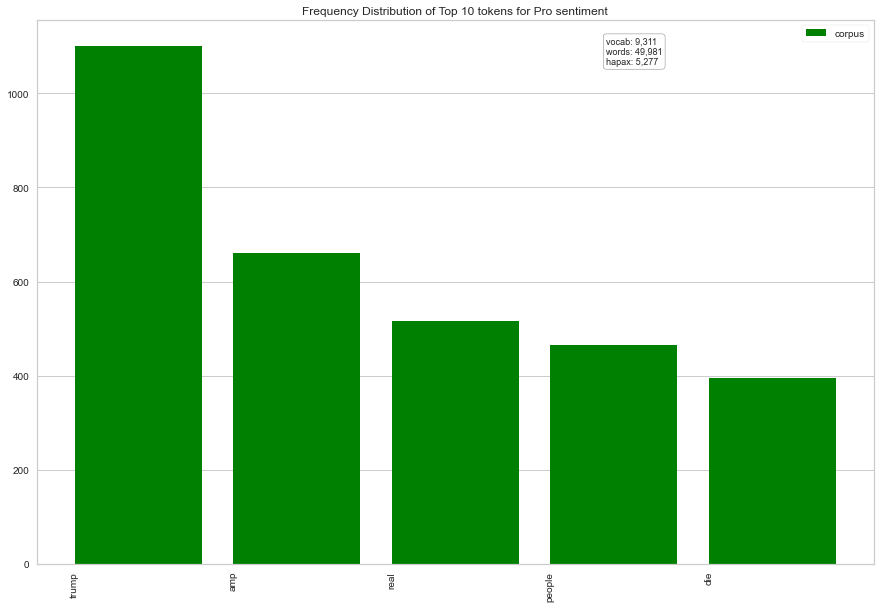

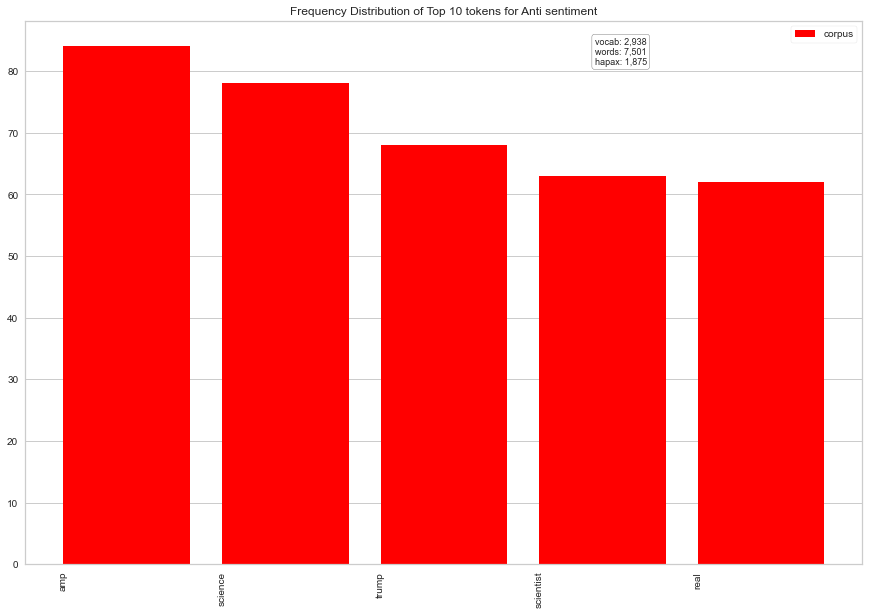

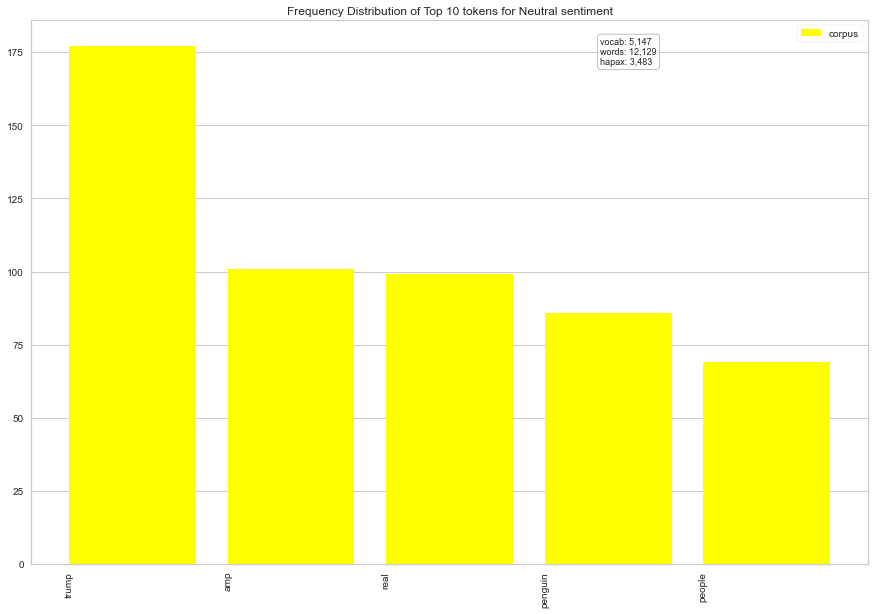

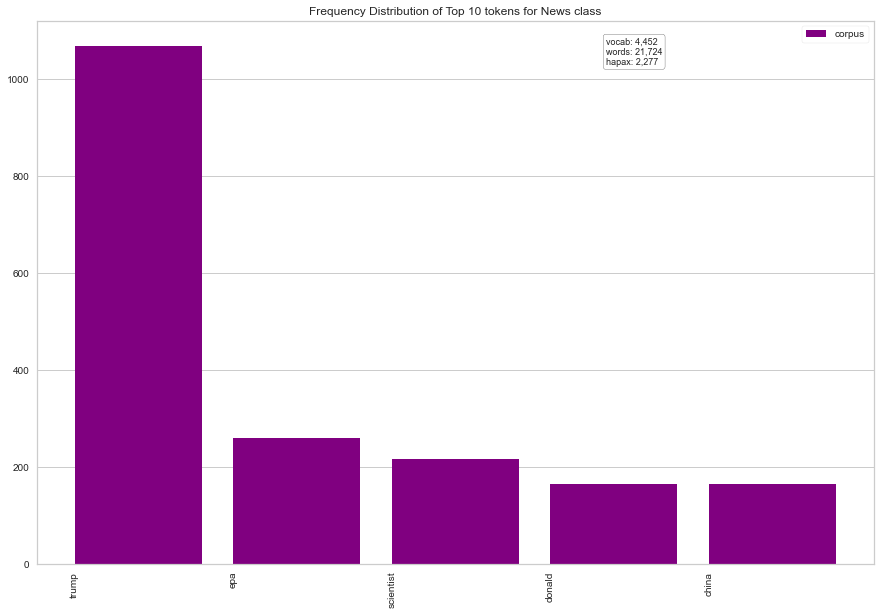

<AxesSubplot:title={'center':'Frequency Distribution of Top 10 tokens for News class'}>

In [35]:
# Create a frequency distribution plot to display the most frequent words associated with the positive sentiment
viz_pos = FreqDistVisualizer(features = features_pos, orient = 'v', n = 5, color = 'green',
                            title = 'Frequency Distribution of Top 10 tokens for Pro sentiment')
#Enlargen the plot
visualizer_pos = RadViz(classes = docs_pos, features = features_pos, size = (1080, 720))

# Fit the vectorized bag of words to the instantiated frequency distribution plot
viz_pos.fit(docs_pos)
viz_pos.show() # Display the graph of positive sentiment words

# Create a frequency distribution plot to display the most frequent words associated with the negative sentiment
viz_neg = FreqDistVisualizer(features = features_neg, orient = 'v', n = 5, color = 'red',
                            title = 'Frequency Distribution of Top 10 tokens for Anti sentiment')
# Enlargen the plot
visualizer_pos = RadViz(classes = docs_pos, features = features_pos, size = (1080, 720))

# Fit the vectorized bag of words to the instantiated frequency distribution plot
viz_neg.fit(docs_neg)
viz_neg.show() # Display the graph of negative sentiment words

# Create a frequency distribution plot to display the most frequent words associated with the neutral sentiment
viz_neutral = FreqDistVisualizer(features = features_neutral, orient = 'v', n = 5, color = 'yellow',
                                title = 'Frequency Distribution of Top 10 tokens for Neutral sentiment')
#Enalargen the plot
visualizer_neutral = RadViz(classes = docs_pos, features = features_pos, size = (1080, 720))

# Fit the vectorized bag of words to the instantiated frequency distribution plot
viz_neutral.fit(docs_neutral)
viz_neutral.show() # Display the graph of neutral sentiment words

# Create a frequency distribution plot to display the most frequent words associated with the news sentiment
viz_news = FreqDistVisualizer(features = features_news, orient = 'v', n = 5, color = 'purple',
                             title = 'Frequency Distribution of Top 10 tokens for News class')
# Enlargen the plot
visualizer_pnews = RadViz(classes = docs_pos, features = features_pos, size = (1080, 720))

# Fit the vectorized bag of words to the instantiated frequency distribution plot
viz_news.fit(docs_news)
viz_news.show() # Display the graph of news sentiment words

Once again the word **trump** has a high frequency in all four classes, being the high mentioned word in three of the classes (it is third in the negative class).  Key word **amp** has a high frequency in three classes (excluding the news class), as before, this could refer to the "Adaptive Management Plan".  Surprisingly, **hoax** appears less frequently than thought before, and **real** appears more frequently.



## 6. Feature Extraction

<a id='vect'></a>
[Back to table of contents](#toc)

Having complete a thorough exploratory analysis of the training data, the original training dataset is cleaned once more in order to better prepare it for model training.

In [36]:
# Create a function that cleans the training data and prepares it for modelling
def preprocessing(string):
    """This function takes a sentence and transforms it to lowercase using the lower() string method, it then removed urls,
       numerical values, punctuation, and rts (retweets) using regex patterns.  The function also use TweetTokenizer from the
       nltk.tokenize library in order to remove twitter handles
       
       Parameters
       ----------
       string : str
           A sentence string which is to go through text cleaning
           
       Returns
       -------
       str
           A string which has been cleaned of noise"""
    
    # Change the casing in the inputted string to lowercase
    string = string.lower()
    
    # Remove url addresses from the string
    string = re.sub(r"http\S+", "", string)
    
    # Instantiate TweetTokenizer with an argument that allows for the stripping of twitter handles
    tknzr = TweetTokenizer(strip_handles = True)
    
    # Tokenize the string using TweetTokenizer in order to remove twitter handles
    string = tknzr.tokenize(string)
    
    # Join the tokenized words together into sentences 
    string = " ".join(string)
    
    # Remove punctuation from the string 
    string = re.sub(r'[^a-z0-9\s]', '', string)
    string = re.sub(r'[0-9]+', '', string) # replace numbers or number like words with 'number'
    
    # Remove rt from the string
    message = re.sub(r'^rt', '', string)
    
    # Return a new string which has been cleaned of noise
    return message

### 6.1. CountVectorizer

In order to create features from text, a vectorizer is used in order to create a bag of words where each word is encoded to either a 1 or 0 depending on whether is appears in that observation (1) or not (0).  The words are the features while the encoding of absence or presence are the values within these features for each observation

Before vectorization can take place, the data needs to be cleared of noise.

In [37]:
# Create a copy our the training data set, train_data, which will be used to build the models
train_data = train.copy()

# Call the created function preprocessing on train_data dataframe message column in order to clear the tweets of noise 
train_data['message']= train_data['message'].apply(preprocessing)

With a clean dataframe, train_data in hand, predictors X and label y need to be defined from the dataframe before X can be fed into the vectorizer for encoding and feature creation

In [38]:
# The label, y, is defined as the sentiment column in the dataframe, train_data
y = train_data.sentiment

# The predictors, X, are defined as the message column in the dataframe, train_data
predictors = train_data.message 

# View the shape of the label and predictors
print(predictors.shape) # predictors
print(y.shape) # label

(15819,)
(15819,)


Finally `CountVectorizer` is used to encode the words in the document, thus creating features that can be used to build a model

In [39]:
# Instantiate CountVectorizer with the ngrams argument as cv
cv = CountVectorizer(ngram_range =(1,2))

# Use cv to vectorize the text data in the message columnn of the dataframe, creating a new vector, X
X = cv.fit_transform(predictors)

# View the shape of vectorized the sparse matrix
print("The predictors have the shape:", X.shape)

The predictors have the shape: (15819, 101170)


### 6.2. Train Test Split

When building a model, it is advisable to create a validation set which can be used when tweaking a model for best performance. The validation set is used in place of the true test set in order to assess model performance.  And once the model is satisfactory it can be used on the test set, which will then give the final performance of a model. For this purpose `train_test_split`, from the SciKit learn `model_selection` library is used.

In [40]:
# Train test split is called on the variables X and y to create a training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

The data after splitting:

In [41]:
# Print the shape of the X training variable, X_train 
print(f'The X training variable has the shape: {X_train.shape}')

# Print the shape of the y training variable, y_train
print(f'The y training variable has the shape: {y_train.shape}')

# Print the shape of the X validation variable, X_val
print(f'The X validation variable has the shape: {X_val.shape}')

#Print the shape of the y validation variable, y_val
print(f'The y validation variable has the shape: {y_val.shape}')

The X training variable has the shape: (12655, 101170)
The y training variable has the shape: (12655,)
The X validation variable has the shape: (3164, 101170)
The y validation variable has the shape: (3164,)


## 7. Model Training

<a id='modelling'></a>
[Back to table of contents](#toc)

Now that the data has been processed, the model training can begin. Three models are trained and test in this section.

### 7.1. Logistic Regression Classifier

**Basic Concept**

A low flexibility, high bias model which fits a sigmoid linear model to binary data by sequeezing a linear regression model (where it gets its name) between values 0 and 1. It does this using `logit functions (sigmoid)`, which help derive a relationship between the dependent variable and independent variables by predicting the probabilities or chances of an observation belonging to one class over another. Classification to one class over another is done using a defined threshold, usually 0.5 for well balanced data, where if the probability is greater than 0.5 it is classified to class 1 and if it is less than 0.5 it is classified to class 0.

**Parameters**

- **random_state**: Arbitary number that allows for reproducability of results
- **penalty**: A choice of the type of regularization to use.  'l2' (penalize close to zero) or 'l1' (penalize to zero). l2 if the default.
- **solver**: Defines which optimization algorithm should be used.
- **multi_class**: Defines how the model should deal with instances where there are more than two classes. 'ovr' or '           'multinomial'.

The data has more than two classes, logistic regression by default be fit on multi class data, therefore the hyperparameter "multi_class" is set to "ovr" which is One vs Rest.  This refers to the model being fitted to one class vs the others as a single unit, the 'one' model is switched out until all model are used as the 'one'. 

In [42]:
# Instantiate the Logistic Regression model as logreg
logreg = LogisticRegression(multi_class = 'ovr', solver = 'liblinear', random_state = 42) 

In [43]:
# Fit the model to our training data
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')

In [44]:
# Make predictions on the validation set
y_logreg = logreg.predict(X_val)

#### 7.1.1. Model Performance

Model Accuracy Metrics Used
- Confusion Matrix
- Classification Report
- F1_score 

**Confusion Matrix**

`Confusion matrixes` show the number of observations that were predicted to the four sentiment classes against the number of observations that actually belong to those classes.

In [45]:
# Define the labels to be used in the confusion matrix
true_labels = ['true : Anti', 'true : Neutral', 'true : Pro', 'true : News']
pred_labels = ['pred : Anti', 'pred : Neutral', 'pred : Pro', 'pred : News']
type_labels = ['-1 : Anti', '0 : Neutral', '1 : Pro', '2 : News']

In [46]:
# Create the confusion matrix dataframe to visualise the number of correctly predicted observations
pd.DataFrame(data = confusion_matrix(y_val, y_logreg), index = true_labels, columns = pred_labels)

pred : Anti  pred : Neutral  pred : Pro  pred : News
true : Anti             114              42         112           10
true : Neutral           15             183         192           35
true : Pro               16              66        1543          130
true : News               4              13         148          541

Each row represents the ground truth total number of observations for the **Pro**, **Neutral**, **Anti**, and **News** sentiment classes. While the columns represent the predicted total number of observations. The number of observation predicted correctly lie on the left to right diagonal.  Therefore, of the total number of observations in the **Anti** class, only 114 tweets were classified correctly, 183 tweets were classified correctly in the **Neutral** class, 1543 tweets were classified correctly in the **Pro** class, and finally 542 were classified correctly for the **News** class.

**Classification Report** 

A classification report shows the precision, recall and f1 scores of the model's performance:
- **Precision**: A measure of how many observations predicted to a class predicted correctly.
- **Recall**: A measure of how many of the true class observation were predicted correctly
- **F1 Score**: The average of the precision and recall scores

In [47]:
# Create a classification report from the validation set
logreg_report = classification_report(y_val, y_logreg, target_names=type_labels)

# Print out the classification report 
print(logreg_report)

              precision    recall  f1-score   support

   -1 : Anti       0.77      0.41      0.53       278
 0 : Neutral       0.60      0.43      0.50       425
     1 : Pro       0.77      0.88      0.82      1755
    2 : News       0.76      0.77      0.76       706

    accuracy                           0.75      3164
   macro avg       0.72      0.62      0.65      3164
weighted avg       0.75      0.75      0.74      3164



The imbalance in the data is evident in the classification report scores.  

**F1 Score**

In [48]:
f1_score_logreg = f1_score(y_val,y_logreg,average ="weighted") 
print(f'This is the accuracy for the basic LogisticRegression classifier: {f1_score_logreg}')

This is the accuracy for the basic LogisticRegression classifier: 0.7405999576244999


The classification report furter reinforces our knowledge gained from the confusion matrix. Our model is severly underperforming on the Anti and Neutral classes.

From the assessing the f1_score classifier seems to have performed well but because of the classification report we realised that the model performed very extremely unbalanced. The strategy chosen to deal with the unbalanced data is SMOTE. SMOTE abilities to synthesize data made 'attractive' and will not make model to overfit.

### 7.2. SMOTE Logistic Regression Classifier

The model above underperforms on the minority classes. This is likely due to the imbalance in the tweets in each class.  The more observations a class has, the more better the model gets at predicting to that class.  In order to attempt to rectify this, resampling is performed.  In this section `SMOTE` (Synthetic Minority over Sampling Technique) is the resampling method used.

It is a preprocessing technique that is considered to be one of the most reliable techniques when dealing with a imbalanced dataset.

The aim of `SMOTE` is to undergo interpolation within data of minority class samples so that their numbers can be increased. This helps in achieving generalization in classification. It is one of the most widely used methods which is applied to cater problems which arise due to the imbalanced number of classification instances in a dataset.

In `SMOTE`, the minority class is generally oversampled by generating artificial samples. Feature space of minority class is used for the generation of these samples. On the basis of requirement regarding sampling need, numbers of neighbors are chosen. A line is constructed along with the minority class data points via the usage of these neighbors. SMOTE tends to equalize the number of majority and minority class instances in training samples.

In [49]:
# Instantiate SMOTE as sm
sm = SMOTE(random_state = 42) 

In [50]:
# Fit the SMOTE model on the training data
X_res, y_res = sm.fit_resample(X_train, y_train) 

We have instantiating and fitted and resample the data now whats left is 

In [51]:
# Instantiate a Logistic Regression model to use with the resampled data as logreg_smote 
logreg_smote = LogisticRegression(multi_class = 'ovr', solver = 'liblinear', random_state = 42)

In [52]:
# Fit the logistic regression model on the resampled data
logreg_smote.fit(X_res, y_res)

LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')

In [53]:
# Predict on the validation set
y_logreg_smote = logreg_smote.predict(X_val)

#### 7.1.2. Model Performance 

Model Accuracy Metrics Used
- Confusion Matrix
- Classification Report
- F1_score 

**Confusion Matrix**

In [54]:
# Create a confusion matrix on the validation data
pd.DataFrame(data = confusion_matrix(y_val, y_logreg_smote), index = true_labels, columns = pred_labels)

pred : Anti  pred : Neutral  pred : Pro  pred : News
true : Anti             145              39          80           14
true : Neutral           58             182         140           45
true : Pro               71             105        1409          170
true : News              17              24          91          574

Each row represents the ground truth total number of observations for the Pro, Neutral, Anti, and News sentiment classes. While the columns represent the predicted total number of observations. The number of observation predicted correctly lie on the left to right diagonal. Therefore, of the total number of observations in the Anti class, only 146 tweets were classified correctly, 182 tweets were classified correctly in the Neutral class, 1409 tweets were classified correctly in the Pro class, and finally 574 were classified correctly for the News class.

**Classifiction Report** 

In [55]:
# classification report on the validation set
smote_report = classification_report(y_val, y_logreg_smote, target_names = type_labels)

# Print the classification report
print(smote_report)

              precision    recall  f1-score   support

   -1 : Anti       0.50      0.52      0.51       278
 0 : Neutral       0.52      0.43      0.47       425
     1 : Pro       0.82      0.80      0.81      1755
    2 : News       0.71      0.81      0.76       706

    accuracy                           0.73      3164
   macro avg       0.64      0.64      0.64      3164
weighted avg       0.73      0.73      0.73      3164



**F1 Score**

In [56]:
# Calcuate the f1 score on the validation set
f1_score_logreg_smote = f1_score(y_val, y_logreg_smote, average = "weighted")

# Print the f1 score
print(f'This is the accuracy for the basic LogisticRegression classifier: {f1_score_logreg_smote}')

This is the accuracy for the basic LogisticRegression classifier: 0.7274317818071886


**Comparison**

In [57]:
# Create a dataframe to show the f1 scores of the basic logistic regression model vs the smote logistic regression model

# Create a list of f1 scores
f1_scores = [f1_score_logreg, f1_score_logreg_smote]

# Create a list to use as row labels
models = ["logreg(no smote)","logreg(with smote)"] 

# Create metric column name list
metrics = ['f1_score']

# Create the dataframe
model_df = pd.DataFrame(data = f1_scores, index = models, columns = metrics)

# Display the first 5 rows of the new dataframe
model_df.head()

f1_score
logreg(no smote)    0.740600
logreg(with smote)  0.727432

The Logistic Regression model appears to perform better with without SMOTE.

###  7.3. Support Vector Classifier

**Basic Concept**

Support Vector Machine (SVM) is a supervised machine learning algorithm which can be employed in both regression and classification problems. SVM constructs a hyperplane in multidimensional space to separate different classes. SVM generates optimal hyperplane in an iterative manner, which is used to minimize an error. The core idea of SVM is to find a maximum marginal hyperplane (MMH) that best divides the dataset into classes.

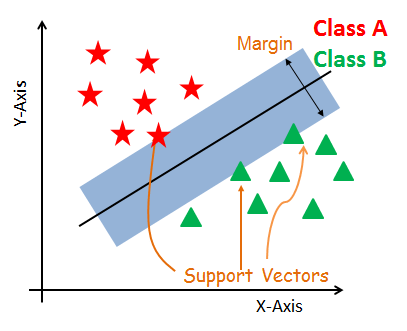

Support vectors are the data points, which are closest to the hyperplane. These points will define the separating line better by calculating margins. These points are more relevant to the construction of the classifier.

A hyperplane is a decision plane which separates between a set of objects having different class memberships.

A margin is a gap between the two lines on the closest class points. This is calculated as the perpendicular distance from the line to support vectors or closest points. If the margin is larger in between the classes, then it is considered a good margin, a smaller margin is a bad margin.

Now that we've covered the basics of a SVM, let's start to apply the SVM.

In [58]:
# Instantiate the support vector classifier model as svm_clf 
svm_clf = SVC(C = 10, gamma = 0.01)

In [59]:
# Fit the model on the training data
svm_clf.fit(X_train, y_train)

SVC(C=10, gamma=0.01)

In [62]:
# Predict on the validation set
y_svm_CV = svm_clf.predict(X_val)

#### 7.2.1. Model Performance

Model Accuracy Metrics Used
- Confusion Matrix
- Classification Report
- F1_score 

**Confusion Matrix**

In [63]:
# Create a dataframe to display the confusion matrix results
pd.DataFrame(data = confusion_matrix(y_val, y_svm_CV), index = true_labels, columns = pred_labels)

pred : Anti  pred : Neutral  pred : Pro  pred : News
true : Anti             119              43         110            6
true : Neutral           16             193         193           23
true : Pro               16              77        1535          127
true : News               2              22         127          555

Each row represents the ground truth total number of observations for the Pro, Neutral, Anti, and News sentiment classes. While the columns represent the predicted total number of observations. The number of observation predicted correctly lie on the left to right diagonal. Therefore, of the total number of observations in the Anti class, only 119 tweets were classified correctly, 192 tweets were classified correctly in the Neutral class, 1535 tweets were classified correctly in the Pro class, and finally 555 were classified correctly for the News class.

**Classfication Report** 

In [64]:
# Print the classification report the validation set
print(classification_report(y_val, y_svm_CV, target_names = type_labels))

              precision    recall  f1-score   support

   -1 : Anti       0.78      0.43      0.55       278
 0 : Neutral       0.58      0.45      0.51       425
     1 : Pro       0.78      0.87      0.83      1755
    2 : News       0.78      0.79      0.78       706

    accuracy                           0.76      3164
   macro avg       0.73      0.64      0.67      3164
weighted avg       0.75      0.76      0.75      3164



**F1 Score**

In [65]:
# Calculate the f1 score on the validation set
f1_score_svm = f1_score(y_val, y_svm_CV, average = "weighted") 

# Print the f1 score
print(f'This is the accuracy for the basic Support Vector Machine classifier: {f1_score_svm}')

This is the accuracy for the basic Support Vector Machine classifier: 0.7492909088603493


### 7.3. SMOTE Support Vector Classifier

In [66]:
# Instantiate a support vector classifier model to use on the resampled data
svm_clf_CV_smote = SVC(C = 10, gamma = 0.01)

# Fit the model on the resampled data
svm_clf_CV_smote.fit(X_res,y_res)

SVC(C=10, gamma=0.01)

In [68]:
# Predict using the validation set
y_pred_svm_CV_smote = svm_clf_CV_smote.predict(X_val)

#### 7.2.1. Model Performance

Model Accuracy Metrics Used
- Confusion Matrix
- Classification Report
- F1_score 

**Confusion Matrix**

In [69]:
# Create a dataframe to display the confusion matrix results
pd.DataFrame(data = confusion_matrix(y_val, y_pred_svm_CV_smote), index = true_labels, columns = pred_labels)

pred : Anti  pred : Neutral  pred : Pro  pred : News
true : Anti             127              36         110            5
true : Neutral           47             167         189           22
true : Pro               56              88        1486          125
true : News              19              40         118          529

Each row represents the ground truth total number of observations for the Pro, Neutral, Anti, and News sentiment classes. While the columns represent the predicted total number of observations. The number of observation predicted correctly lie on the left to right diagonal. Therefore, of the total number of observations in the Anti class, only 127 tweets were classified correctly, 167 tweets were classified correctly in the Neutral class, 1486 tweets were classified correctly in the Pro class, and finally 529 were classified correctly for the News class.

**Classification Report**

In [70]:
# Print the classification report the validation set
print(classification_report(y_val, y_pred_svm_CV_smote, target_names = type_labels))

              precision    recall  f1-score   support

   -1 : Anti       0.51      0.46      0.48       278
 0 : Neutral       0.50      0.39      0.44       425
     1 : Pro       0.78      0.85      0.81      1755
    2 : News       0.78      0.75      0.76       706

    accuracy                           0.73      3164
   macro avg       0.64      0.61      0.62      3164
weighted avg       0.72      0.73      0.72      3164



**F1 Score**

In [71]:
# Calculate the f1 score on the validation set
f1_svm_CV_smote = f1_score(y_val, y_pred_svm_CV_smote, average = "weighted") 

# Print the f1 score
print(f'This is the accuracy for the basic Support Vector Machine classifier: {f1_score_svm}')

This is the accuracy for the basic Support Vector Machine classifier: 0.7492909088603493


**Comparison**

In [72]:
# Create a dataframe to show the f1 scores of the basic support vector classifier model vs the smote support vector classifier
# model

# Create a list of f1 scores
f1_scores = [f1_score_svm, f1_svm_CV_smote]

# Create a list to use as row labels
models = ["svc(no smote)","svc(with smote)"] 

# Create metric column name list
metrics = ['f1_score']

# Create the dataframe
model_df = pd.DataFrame(data = f1_scores, index = models, columns = metrics)

# Display the first 5 rows of the new dataframe
model_df.head()

f1_score
svc(no smote)    0.749291
svc(with smote)  0.722556

Again we see that applying SMOTE to our data seems to have a negative effect on the model performance.

### 7.3. Naive Bayes Classifier

**Basic Concept**

Naive Bayes is a statistical classification technique based on Bayes Theorem. It is one of the simplest supervised learning algorithms. Naive Bayes classifier is the fast, accurate and reliable algorithm. Naive Bayes classifiers have high accuracy and speed on large datasets.

Naive Bayes classifier assumes that the effect of a particular feature in a class is independent of other features. For example, a loan applicant is desirable or not depending on his/her income, previous loan and transaction history, age, and location. Even if these features are interdependent, these features are still considered independently. This assumption simplifies computation, and that's why it is considered as naive. This assumption is called class conditional independence.

$ P(h|D) = \frac{P(D|h)P(h)}{P(D)} $

P(h): the probability of hypothesis h being true (regardless of the data). This is known as the prior probability of h.
P(D): the probability of the data (regardless of the hypothesis). This is known as the prior probability.
P(h|D): the probability of hypothesis h given the data D. This is known as posterior probability.
P(D|h): the probability of data d given that the hypothesis h was true. This is known as posterior probability.

In [73]:
# Instantiate the naive bayes model as nb
nb = MultinomialNB() 

In [74]:
# Fit the model on the training data
nb.fit(X_train, y_train)

MultinomialNB()

In [75]:
# Predict on the validation data
pred_nb = nb.predict(X_val)

#### 7.3.1. Model Performance

**Confusion Matrix**

Model Accuracy Metrics Used
- Confusion Matrix
- Classification Report
- F1_score 

In [76]:
# Create a dataframe to display the confusion matrix results
pd.DataFrame(data = confusion_matrix(y_val, pred_nb), index = true_labels, columns = pred_labels)

pred : Anti  pred : Neutral  pred : Pro  pred : News
true : Anti              63              44         160           11
true : Neutral            6             142         232           45
true : Pro                5              57        1535          158
true : News               2               8         151          545

Each row represents the ground truth total number of observations for the **Pro**, **Neutral**, **Anti**, and **News** sentiment classes. While the columns represent the predicted total number of observations. The number of observation predicted correctly lie on the left to right diagonal. Therefore, of the total number of observations in the **Anti** class, only 63 tweets were classified correctly, 142 tweets were classified correctly in the **Neutral** class, 1535 tweets were classified correctly in the **Pro** class, and finally 545 were classified correctly for the **News** class.

In [77]:
# Print the classification on the validation set
print(classification_report(y_val, pred_nb, target_names = type_labels))

              precision    recall  f1-score   support

   -1 : Anti       0.83      0.23      0.36       278
 0 : Neutral       0.57      0.33      0.42       425
     1 : Pro       0.74      0.87      0.80      1755
    2 : News       0.72      0.77      0.74       706

    accuracy                           0.72      3164
   macro avg       0.71      0.55      0.58      3164
weighted avg       0.72      0.72      0.70      3164



In [78]:
# Calculate the f1 score on the validation set
f1_nb = f1_score(y_val, pred_nb, average = "weighted") 

# Print the f1 score
print(f'This is the accuracy for the Naive Bayes classifier: {f1_score_svm}')

This is the accuracy for the Naive Bayes classifier: 0.7492909088603493


### 7.4. SMOTE Naive Bayes Classifier

In [79]:
# Instantiate the naive bayes classifier as nb_smote to use on the resampled data
nb_smote = MultinomialNB()

In [80]:
# Fit the model on the resampled data
nb_smote.fit(X_res, y_res)

MultinomialNB()

In [81]:
# Predict of the validation set
pred_nbsmote = nb_smote.predict(X_val)

#### 7.4.1. Model Performance

**Confusion Matrix**

Model Accuracy Metrics Used
- Confusion Matrix
- Classification Report
- F1_score 

In [82]:
# Create a dataframe to display the confusion matrix results
pd.DataFrame(data = confusion_matrix(y_val, pred_nbsmote), index = true_labels, columns = pred_labels)

pred : Anti  pred : Neutral  pred : Pro  pred : News
true : Anti             136              43          86           13
true : Neutral           49             177         149           50
true : Pro               74             127        1343          211
true : News              18              18          89          581

Each row represents the ground truth total number of observations for the **Pro**, **Neutral**, **Anti**, and **News** sentiment classes. While the columns represent the predicted total number of observations. The number of observation predicted correctly lie on the left to right diagonal. Therefore, of the total number of observations in the **Anti** class, only 136 tweets were classified correctly, 177 tweets were classified correctly in the **Neutral** class, 1343 tweets were classified correctly in the **Pro** class, and finally 581 were classified correctly for the **News** class.

In [83]:
# Print the classification report of the validation set
print(classification_report(y_val, pred_nbsmote, target_names = type_labels))

              precision    recall  f1-score   support

   -1 : Anti       0.49      0.49      0.49       278
 0 : Neutral       0.48      0.42      0.45       425
     1 : Pro       0.81      0.77      0.78      1755
    2 : News       0.68      0.82      0.74       706

    accuracy                           0.71      3164
   macro avg       0.62      0.62      0.62      3164
weighted avg       0.71      0.71      0.70      3164



In [84]:
# Calculate the f1 score on the validation set
f1_nb_smote = f1_score(y_val, pred_nbsmote, average = "weighted") 

# Print the f1 score
print(f'This is the accuracy for the Naive Bayes classifier: {f1_score_svm}')

This is the accuracy for the Naive Bayes classifier: 0.7492909088603493


In [85]:
# Create a dataframe to show the f1 scores of the Naive Bayes classifier model vs the smote Naive Bayes classifier
# model

# Create a list of f1 scores
f1_scores = [f1_nb, f1_nb_smote]

# Create a list to use as row labels
models = ["NB (no smote)","NB (with smote)"] 

# Create metric column name list
metrics = ['f1_score']

# Create the dataframe
model_df = pd.DataFrame(data = f1_scores, index = models, columns = metrics)

# Display the first 5 rows of the new dataframe
model_df.head()

f1_score
NB (no smote)    0.697987
NB (with smote)  0.704730

Of the three models investigated, it seems that only the Naive Bayes model was postively affected by the implentation of SMOTE.

# Model Validation

Model validation is the process by which model outputs are compared to independent real-world observations to judge how well the model performed. 

Model validation ensures the effectiveness and accuracy of a trained model in preparation for use. Without model validation, the model may perform poorly. A model that is not properly validated will not be robust enough to adapt to new scenarios or may be too overfitted to receive and properly use new inputs.

### K-fold cross validation

There are many methods of comparing models, which is an important part of model validation. K-fold cross validation is one such method. In k-fold cross validation, the training set is randomly split into k groups. Then, iterated k times, one holds out each unique group, trains the model on the remaining data, and evaluates the model on that group. Performance is averaged over each k iteration of the cross validation.

K-fold cross validation can be implemented using `cross_val_score` from `sklearn`.

In [ ]:
# define classifiers that we'll apply cross validation to
clf1 = logreg
clf2 = svm_clf
clf3 = nb

# create empty list where we'll append the f1 score's mean and std of each classifier obtained through cross validation
cross_val = []

# loop through list of classifiers and apply cross_val_score function
for clf, label in zip([clf1,clf2,clf3],['Logistic Regresion','SVM', 'Naive Bayes']):
    print(label)
    scores = cross_val_score(clf, X, y, cv=5, scoring = 'f1_micro')
    print("f1 score: {:0.4f} (+/- {:0.4f})".format(scores.mean(), scores.std()))
    cross_val.append([label, scores.mean(), scores.std() ]) # append the scores to the empty list created above

In [72]:
# convert list of cv scores to dataframe
cross_val = pd.DataFrame(cross_val, columns=['Model', 'CV_Mean', 'CV_Std_Dev'])
cross_val.set_index('Model', inplace=True) # set index to the name of model

In [73]:
# view our dataframe containing cross valiation mean and std
cross_val

CV_Mean  CV_Std_Dev
Model                                   
Logistic Regresion  0.745054    0.004227
SVM                 0.743031    0.002489
Naive Bayes         0.711612    0.001393

The low standard deviation indicates that our models does not vary a lot with different subsets of training data. Thus, it seems our Naive Bayes has the lowest variance. However, the Logistic Regression model performs best on the data, indicating that it has the lowest bias out of all the models. Combined with the low variance, the Logistic Regression model seems to be the most robust model.

## 8. Test Data
<a id='tes'></a>
[Back to table of contents](#toc)

Finally the testing dataset can be use to create a final test of the model.  The models will be tested on the testing data and then uploaded onto Kaggle where they will be test for accuracy using th f1 score metric.

In [74]:
# Create a copy of the test to perform noise cleaning and vectorization on
test_data = test.copy()

In [75]:
# Call the data cleaning function the test_data dataframe to remove noise in preparation for cleaning
test_data['message'] = test_data['message'].apply(preprocessing)

In [76]:
# Use CountVector in order to encode the words in the clean test dataframe
test_cv_trans =  cv.transform(test_data['message'])

# Print out the shape of the newly vectorized dataframe
print("The shape of the data is:", test_cv_trans.shape)

The shape of the data is: (10546, 101172)


### 8.1. Logistic Regression

In [77]:
# predict on test_data
y_pred_logreg_sub = logreg.predict(test_cv_trans)

#### 8.1.1. Logistic Regression Submission

In [78]:
# Extract the tweetid column from test_data to use as the submission file index
tweetid = test_data['tweetid']

In [79]:
# Create a dataframe using the test_data tweetid and and the predicted sentiment
submission_logreg = pd.DataFrame({'tweetid' : tweetid, 'sentiment' : y_pred_logreg_sub})

In [80]:
# Display the last 5 rows of the submission file
submission_logreg.tail()

tweetid  sentiment
10541   895714          1
10542   875167          1
10543    78329          2
10544   867455          0
10545   470892          1

In [84]:
# Save dataframe to a csv file for submission
submission_logreg.to_csv("AM3_logreg_predictions.csv", index = False)

### 8.2. Support Vector

In [81]:
# predict on test_data
y_pred_svm_sub = svm_clf.predict(test_cv_trans)

#### 8.2.1 Support Vector Submission

In [82]:
# Create a dataframe using the test_data tweetid and and the predicted sentiment
submission_svc = pd.DataFrame({'tweetid' : tweetid, 'sentiment' : y_pred_svm_sub})

In [83]:
# Display the last 5 rows of the submission file
submission_svc.tail()

tweetid  sentiment
10541   895714          1
10542   875167          1
10543    78329          0
10544   867455          0
10545   470892          1

In [85]:
# Save dataframe to a csv file for submission
submission_svc.to_csv("AM3_SVC_predictions.csv", index = False)

### 8.3. Naive Bayes

In [86]:
y_pred_nb = nb.predict(test_cv_trans)

#### 8.3.1. Naive Bayes Submission

In [87]:
# Create a dataframe using the test_data tweetid and and the predicted sentiment
submission_nb = pd.DataFrame({'tweetid' : tweetid, 'sentiment' : y_pred_nb})

In [88]:
# Display the last 5 rows of the submission file
submission_nb.tail()

tweetid  sentiment
10541   895714          1
10542   875167          1
10543    78329          1
10544   867455          0
10545   470892          1

In [89]:
# Save dataframe to a csv file for submission
submission_nb.to_csv("AM3_nb_predictions.csv", index = False)

## 9. Conclusion

### 9.1. Model Findings

**Collecting Train prediction data**

To compare with other findings


In [87]:
# Make predictions on the train set
train_pred_logreg = logreg.predict(X_train)
f1_score_train_logreg = f1_score(y_train,train_pred_logreg,average = "weighted") # Train set

In [88]:
# Predict on the validation set
train_pred_logreg_smote = logreg_smote.predict(X_train) # Train_set
f1_score_train_logreg_smote =f1_score(y_train,train_pred_logreg_smote,average = "weighted" )

In [89]:
# Predict on the train set 
train_pred_svm_CV = svm_clf.predict(X_train)
# Calculate the f1 score on the train set
f1_score_train_svm = f1_score(y_train, train_pred_svm_CV,average = "weighted")


In [90]:
# Predict using the validation set
train_pred_svm_smote = svm_clf_CV_smote.predict(X_train)
# Calculate the f1 score on the train set
f1_score_train_svm_smote = f1_score(y_train,train_pred_svm_smote, average = "weighted") 

In [91]:
# Predict on the train data
train_pred_nb = nb.predict(X_train)

# Calculate the f1 score on the train set
f1_score_train_nb = f1_score(y_train,train_pred_nb, average = "weighted") 


In [92]:
# Predict of the train set
train_pred_nb_smote = nb_smote.predict(X_train)

# Calculate the f1 score on the train set
f1_score_train_nb_smote = f1_score(y_train,train_pred_nb_smote, average = "weighted") 

In [98]:
 
    """
    Create a dataframe to show the 
    f1 score of the basic models vs the smote models
    
    """
# Create a list of f1 scores
f1_scores_pred = [f1_score_logreg, 
                  f1_score_logreg_smote, 
                  f1_score_svm,
                  f1_svm_CV_smote, 
                  f1_nb,
                  f1_nb_smote]

#Create a list train f1_score
f1_scores_train = [f1_score_train_logreg, f1_score_train_logreg_smote, 
                    f1_score_train_svm, f1_score_train_svm_smote,
                    f1_score_train_nb,  f1_score_train_nb_smote]

# Create a list to use as row labels
models2 = ["LogisticRegression", "LogisticRegression (with SMOTE)",
          "Support Vector Machine", "Support Vector Machine(with SMOTE)",
          " Multinomial_NB", "Multinomial_NB(with SMOTE)"] 

# Create a dictionary of the the f1 scores 
f1_scores_dict = {'model': models,
                  'f1_score_train': f1_scores_train,
                  'f1_score_pred' : f1_scores_pred,
                  }






# Create the dataframe
models_df = pd.DataFrame.from_dict(f1_scores_dict)

#setting the index
models_df = models_df.set_index('model')


# Display the first 5 rows of the new dataframe
models_df

f1_score_train  f1_score_pred
model                                                            
LogisticRegression                        0.992649       0.740600
LogisticRegression (with SMOTE)           0.988727       0.727432
Support Vector Machine                    0.990751       0.749291
Support Vector Machine(with SMOTE)        0.986911       0.722556
 Multinomial_NB                           0.899800       0.697987
Multinomial_NB(with SMOTE)                0.924119       0.704730

Now that this information is in a DataFrame, visualizing  and analysing the performance of the models will become much simpler.

**F1_score analysis**

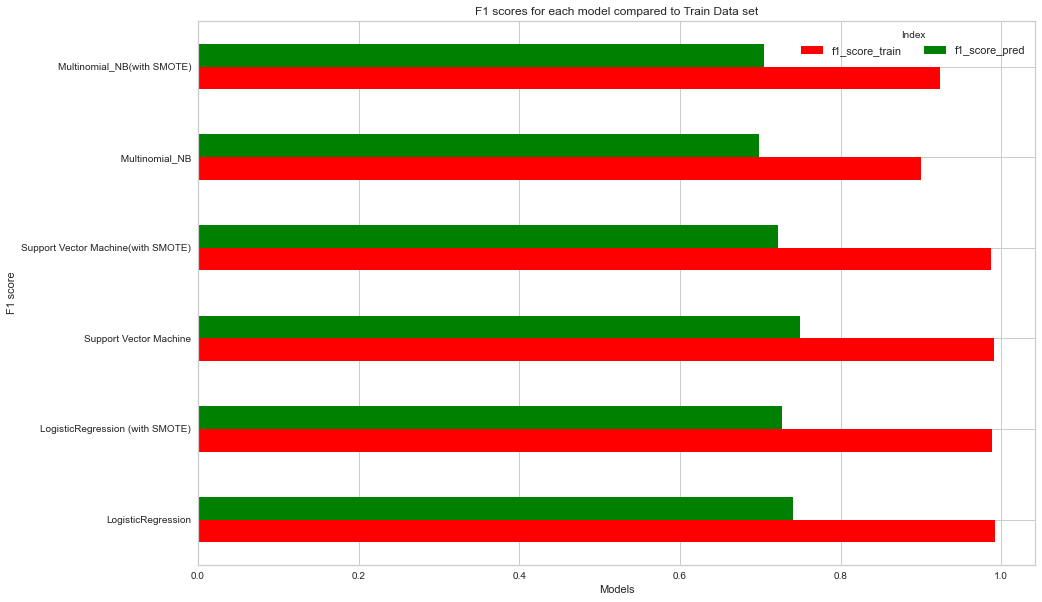

In [99]:
# Plot a bargraph from the data 
models_df.plot.barh(color={"f1_score_train": "red", "f1_score_pred": "green"},figsize = (15,10)).legend( title="Index", 
                    ncol= 2,
                    prop={'size': 11})
plt.title("F1 scores for each model compared to Train Data set") # Set title
plt.xlabel("Models") # Set x label
plt.ylabel("F1 score")# Set y label
plt.show() # plot the graph 

This bar plot indicates whether there are classifiers that were overfitted or underfitted. All the models were most likely overfitting as seen with huge difference in F1 scores . This barplot also shows that most models performed well based on the model_df DataFrame. The classifier that performed most poorly is the Naive Bayes Multinomial classifier with the lowest **f1 score prediction** of **0.69** as shown in the DataFrame and graph. Also all the SMOTE fitted data classifier performed quite lower than non SMOTE trained classifiers.

**ROC_AUC CURVE**

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

Note that the ROC does not depend on the class distribution. This makes it useful for evaluating classifiers predicting rare events such as diseases or disasters. In contrast, evaluating performance using accuracy (TP +

TN)/(TP + TN + FN + FP) would favor classifiers that always predict a negative outcome for rare events.

**Area under curve (AUC)**

To compare different classifiers, it can be useful to summarize the performance of each classifier into a single measure. One common approach is to calculate the area under the ROC curve, which is abbreviated to AUC. It is equivalent to the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance, i.e. it is equivalent to the two sample Wilcoxon rank-sum statistic.

A classifier with high AUC can occassionally score worse in a specific region than another classifier with lower AUC. But in practice, the AUC performs well as a general measure of predictive accuracy.

**Class Prediction Error** 

The Class Prediction Error plot is a twist on other and sometimes more familiar classification model diagnostic tools like the Confusion Matrix and Classification Report. Like the Classification Report, this plot shows the support (number of training samples) for each class in the fitted classification model as a stacked bar chart. Each bar is segmented to show the proportion of predictions (including false negatives and false positives, like a Confusion Matrix) for each class. You can use a ClassPredictionError to visualize which classes your classifier is having a particularly difficult time with, and more importantly, what incorrect answers it is giving on a per-class basis. This often enables better understanding of strengths and weaknesses of different challenges and particular challenges unique to the dataset.

**NOTE**

* ROC AUC curves are mainly for Binary Classification but extended to show which models struggled to classify the different classes

In [100]:
from sklearn.metrics import roc_curve, auc #import the necessary metrics
"""
    This function is to find the ROC_AUC curve and AUC.
    This function also plots the necessary plots.
    Takes in the function(clf), Validations sets(X_test,y_test), number of classes(n_classes) , 
    size of your figure(figsize= tuple of integers) and a figure as ax = none 
"""

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6), ax = None):
    y_score = clf.predict_proba(X_test) #perform a decision_test function

    # Create empty dictionary for the structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    
    # Loop through classes to get the FPR,TPR
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Instatiate a graph
    if(ax is None):
        fig, ax = plt.subplots(figsize=figsize)
    
     #  plot the roc for each class 
    ax.plot(fpr[0], tpr[0], label= f'ROC curve (area = {roc_auc[0]:.2f}) for Class 2')
    ax.plot(fpr[1], tpr[1], label=f'ROC curve (area = {roc_auc[1]:.2f}) for Class -1')    
    ax.plot(fpr[2], tpr[2], label=f'ROC curve (area = {roc_auc[2]:.2f}) for Class 0')
    ax.plot(fpr[3], tpr[3], label=f'ROC curve (area = {roc_auc[3]:.2f}) for Class 1')
    
  
    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0]) # set x 
    ax.set_ylim([0.0, 1.05])# set y
    ax.set_xlabel('False Positive Rate') # Set x label
    ax.set_ylabel('True Positive Rate') # Set y label
    ax.legend(loc="best") # Set legend postion
    
    ax.grid(alpha=.4)
    return ax

**LOGISTIC REGRESSION CLASSIFIER**

**ROC AUC CURVE**

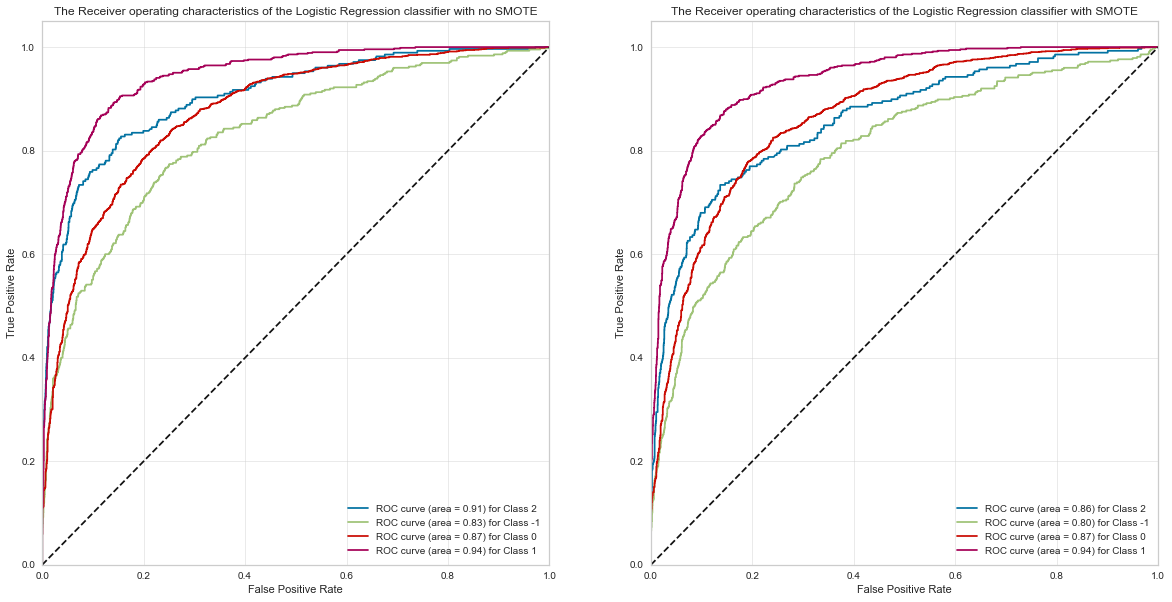

In [101]:
fig = plt.figure(figsize = (8,15))                  # Changed the size of the figure, just aesthetic
ax1 = fig.add_subplot(1,2,1)     # Change the subplot arguments
plot_multiclass_roc(logreg, X_val, y_val, n_classes=4, figsize=(5, 5),ax = ax1)
ax2 = fig.add_subplot(1,2,2)                        # Change the subplot arguments
plot_multiclass_roc(logreg_smote, X_val, y_val, n_classes=4, figsize=(5, 5),ax = ax2)
ax1.set_title("The Receiver operating characteristics of the Logistic Regression classifier with no SMOTE")
ax2.set_title("The Receiver operating characteristics of the Logistic Regression classifier with SMOTE")
plt.gcf().set_size_inches(20, 10)

**CLASS PREDICTION ERROR** 

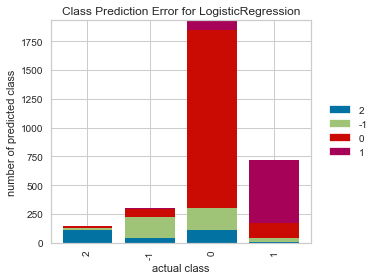

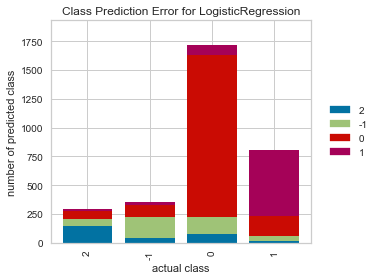

In [102]:
from yellowbrick.classifier import  ClassPredictionError
# Instantiate the classification model and visualizer
logreg_class = ClassPredictionError(
    logreg, classes=[-1,0,1,2]
)

# Fit the training data to the visualizer
logreg_class.fit(X_train, y_train)

# Evaluate the model on the test data
logreg_class.score(X_val, y_val)

# Draw visualization
logreg_class.show()
logreg_class_smote = ClassPredictionError(
    logreg_smote, classes=[-1,0,1,2]
)

# Fit the training data to the visualizer
logreg_class_smote.fit(X_train, y_train)

# Evaluate the model on the test data
logreg_class_smote.score(X_val, y_val)

# Draw visualization
logreg_class_smote.show()


plt.show()

The ROC curve showed that Logistic Regression classifier after trained with smote dataset failed to classify most of the tweets belonging to class -1 whereas it Counterpart classifier failed  to tweets belongin to class 0 and  class -1.

**SUPPORT VECTOR MACHINE**

**CLASS PREDICTION ERROR**

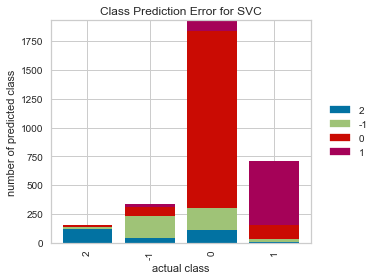

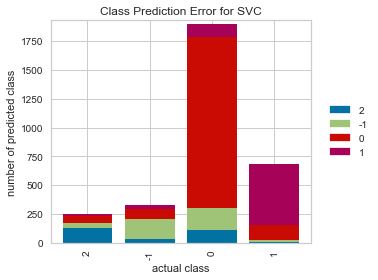

In [103]:
# Instantiate the classification model and visualizer
SVM_class = ClassPredictionError(
    svm_clf, classes=[-1,0,1,2]
)

# Fit the training data to the visualizer
SVM_class.fit(X_train, y_train)

# Evaluate the model on the test data
SVM_class.score(X_val, y_val)

# Draw visualization
SVM_class.show()

# Instantiate the classification model and visualizer
SVM_class_smote = ClassPredictionError(
    svm_clf_CV_smote, classes=[-1,0,1,2]
)

# Fit the training data to the visualizer
SVM_class_smote.fit(X_train, y_train)

# Evaluate the model on the test data
SVM_class_smote.score(X_val, y_val)

# Draw visualization
SVM_class_smote.show()


plt.show()

The Support Vector Model SMOTE classifier struggled to classify the tweet belonging to class 1 and 2 whereas the SUPPORT VECTOR MACHINE with no Smote applied mostly struggle with classifying TWEET belonging to class -1 and 0.

**Naive Bayes Multinomial NB**

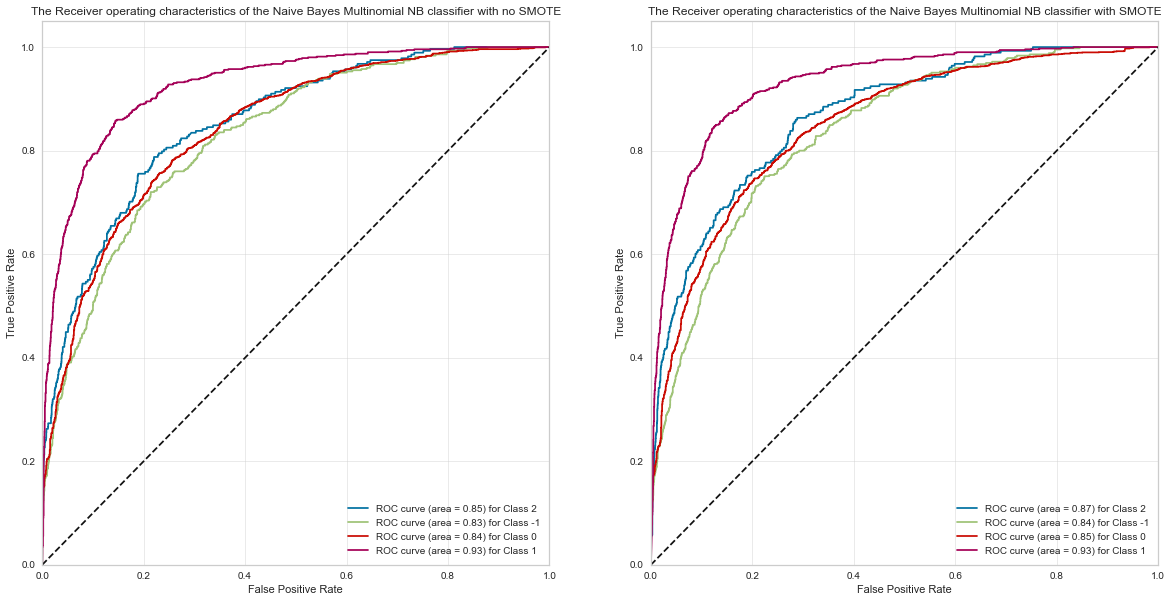

In [104]:
fig3 = plt.figure(figsize = (8,15))                  
ax5 = fig3.add_subplot(1,2,1)     # Change the subplot arguments
plot_multiclass_roc(nb, X_val, y_val, n_classes=4, figsize=(5, 5),ax = ax5)
ax6 = fig3.add_subplot(1,2,2)                        # Change the subplot arguments
plot_multiclass_roc(nb_smote, X_val, y_val, n_classes=4, figsize=(5, 5),ax = ax6) # Call the plot function
ax5.set_title("The Receiver operating characteristics of the Naive Bayes Multinomial NB classifier with no SMOTE")
ax6.set_title("The Receiver operating characteristics of the Naive Bayes Multinomial NB classifier with SMOTE")
 
plt.gcf().set_size_inches(20, 10)

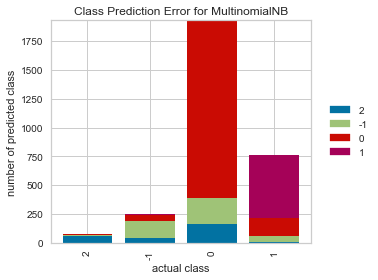

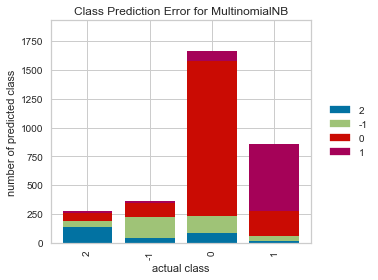

In [105]:
# Instantiate the classification model and visualizer
NB_class = ClassPredictionError(
    nb, classes=[-1,0,1,2]
)

# Fit the training data to the visualizer
NB_class.fit(X_train, y_train)

# Evaluate the model on the test data
NB_class.score(X_val, y_val)

# Draw visualization
NB_class.show()
NB_class_smote = ClassPredictionError(
    nb_smote, classes=[-1,0,1,2]
)

# Fit the training data to the visualizer
NB_class_smote.fit(X_train, y_train)

# Evaluate the model on the test data
NB_class_smote.score(X_val, y_val)

# Draw visualization
NB_class_smote.show()


plt.show()

Both classifiers struggled to classify the tweets in the class -1,0,2

### 9.2. Insights

The Logistic Regression performed well compared to its other counterpart producing an f1_score of 0.74 as well as the accuracy score of 0.75.
* Reasons:
 * The data was linearly separable even though it was multiclassed. Logistic Regression Performs optimally when classified the data is balanced and when there is two classes and assumes that the data is linearly separable. The use of the one vs rest technique allowed to do the classification more simply

The data is extremely unbalanced.
 * This really affected model performance making most of classifier fail to classify the tweets mostly in class other classes besides class one.
 * Class one have more 8000+ observations which made sense that  most all the classifier will mostly predict class one more than the other classes. Looking through the classification reports, f1 scores and ROC AUC curves and class predictions plots, most of the classifier are biased toward class 1.
 
Overfitting of the classifiers:
 * All of the classifiers were overfitting, producing high train prediction score averaging around 0.92 where as the score were f1 scores for the data averaging around

The Naive Bayes Multinomial Classifier performed relative to other classifiers poorly.
 * That data was unbalanced hence performed better with the SMOTE model but due to the huge imbalance even the SMOTE  nb classifier was still prone to error and still struggle to classify between the classes. This classifer was expected to perform better as it is more suited for multi- class classification problems.

**Insights for businesses**

As a business, you would like to know how your actions/marketing campaign/product launch is received by the public. We are living in an era where social media is part of everyone's lives and people are not fearful of to make their feelings known. One of the biggest social media platforms is Twitter. Thus, knowing how people receive your product could give you the edge over your competitors.

Sentiment analysis is a technique which can be used to analyze how negative or positive a text is. When you analyze sentiment in real time you can moniter mentions on social media (and handle negative comments before they escalate), guage customer reactions to your latest marketing campaign or product launch, and get an overall sense of how your customers feel about your company.

You can also perform sentiment analysis periodically, and understand what customers like and dislike about specific aspects of your business ‒ maybe they love your new feature, but are disappointed about your customer service. Those insights can help you make smarter decisions, as they show you exactly what things to improve.

##  10. Model Pickling

**Logistic Regression**

In [ ]:
# Save the model as a pickle file 
model_save_path = "LogisticRegression_model.pkl" # Name the model
with open(model_save_path,'wb') as file: # Create a file
    pickle.dump(logreg,file) # Pickle the model

**Support Vector Classifier**

In [ ]:
# Save the model as a pickle file
model_save_path = "SupportVectorClassifier_model.pkl" # Name the model
with open(model_save_path,'wb') as file: # Create a file
    pickle.dump(svm_clf,file) # Pickle the model

**Naive Bayes**

In [ ]:
# Save the model as a pickle file
model_save_path = "NaiveBayes_model.pkl" # Name the model
with open(model_save_path,'wb') as file: # Create a file
    pickle.dump(nb,file) # Pickle the model

In [ ]:
experiment.end()